In [1]:
import datetime
import logging
import os
import glob 
from datetime import datetime, timedelta

from pathlib import Path
from osgeo import gdal, osr
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, BoundaryNorm
import numpy as np
from pyproj import Transformer
from sklearn.metrics import cohen_kappa_score
from shapely.geometry import LinearRing, Point, Polygon, box
import rasterio
import requests
from pprint import pprint

In [2]:

def gdal_load(path, band):
    """
    Load image file into array
    using gdal.
    
    Inputs
    ------
    path = path to image file, text.
    band = band to load, int.
    
    Returns
    -------
    loaded file as numpy array
    """
    ds = gdal.Open(path, gdal.GA_ReadOnly)
    arr = ds.GetRasterBand(band).ReadAsArray()
    #length, width = ds.RasterYSize, ds.RasterXSize
    # We also save the raster geo info to use them for plotting later 
    # ulx, uly stands for upper left corner, lrx, lry for lower right corner
    ulx, xres, xskew, uly, yskew, yres  = ds.GetGeoTransform()
    x = ulx + np.arange(ds.RasterXSize, dtype=float) * xres
    y = uly + np.arange(ds.RasterYSize, dtype=float) * yres
    # this empties the gdal raster variable that we no longer need since the raster has been saved into and array
    ds = None 
    # summary of load
    #print('Loaded data, length =', arr.shape[0], ', width =', arr.shape[1], ', and data type =', arr.dtype)
    
    return arr, x, y

# colormaps
black_blue = ListedColormap(['black', 'Blue'])
black_white = ListedColormap(['black', 'white'])
black_blue_white = ListedColormap(['black', 'blue', 'white'])
white_blue = LinearSegmentedColormap.from_list('white_blue', ['white', 'blue'])

# simplified HLS colormap

HLS_compare_colors = ['white', 'blue', 'lightblue', 'darkgrey', 'black']  # Custom colors
HLS_compare_cmap = ListedColormap(HLS_compare_colors)
HLS_compare_bounds = [-0.5, 0.5, 1.5, 2.5, 254, 256]
HLS_compare_norm = BoundaryNorm(HLS_compare_bounds, HLS_compare_cmap.N)  

HLS_colors = ['white', 'blue', 'darkgrey', 'black']
HLS_cmap = ListedColormap(HLS_colors)
HLS_bounds = [-0.5, 0.5, 1.5, 254, 256]
HLS_norm = BoundaryNorm(HLS_bounds, HLS_cmap.N)

def generate_water_occurrence_map(data):
    """
    Generate a water occurrence map for the 3D array excluding nonvalid (255) data.

    Parameters:
        data (numpy.ndarray): A 3D numpy array (time, height, width).

    Returns:
        numpy.ndarray: A 2D probability map.
    """
    # Mask to exclude cloud(253) and nonvalid(255) pixels
    valid_mask = (data != 253) & (data != 255)

    # Count the occurrences of 1s and valid (non-255) observations for each pixel
    count_ones = np.sum((data == 1) & valid_mask, axis=-1)
    count_valid = np.sum(valid_mask, axis=-1)

    # Calculate probability, avoiding division by zero
    water_occurrence_map = np.divide(
        count_ones, count_valid, where=(count_valid > 0), out=np.full(count_ones.shape, np.nan, dtype=float)
    )

    return water_occurrence_map


In [3]:
# list HLS and S1 files
mgrs_tile = "10SEH"
read_fp = "/u/aurora-r0/jeon/tools/DSWx-fusion/DSWx-Enhanced-Analysis/download_"
files_HLS = glob.glob(read_fp + mgrs_tile + "/*-HLS_*")
num_HLS = len(files_HLS)
files_HLS_WTR = glob.glob(read_fp + mgrs_tile + "/*-HLS_*_WTR.tif")
num_HLS_WTR = len(files_HLS_WTR)

files_S1 = glob.glob(read_fp + mgrs_tile + "/*-S1_*")
num_S1 = len(files_S1)
files_S1_WTR = glob.glob(read_fp + mgrs_tile + "/*-S1_*_WTR.tif")
num_S1_WTR = len(files_S1_WTR)


In [4]:
### HLS data classes ###
# 0: not water
# 1: open water
# 2: partial surface water
# 252: snow/Ice
# 253: cloud/cloud shadow
# 254: ocean masked
# 255: no data

### S1 data classes ###
# 0: not water
# 1: open water
# 3: inundated vegetation
# 250: HAND mask
# 251: layover/shadow mask
# 255: no data

# load HLS and S1 images and stack it into 3d array

data_stack = []

for fp in files_HLS_WTR:
    
    data, x, y = gdal_load(fp, 1)
    data_stack.append(data)

data_HLS_WTR = np.stack(data_stack, axis = -1)


data_stack = []

for fp in files_S1_WTR:
    
    data, x, y = gdal_load(fp, 1)
    data_stack.append(data)

data_S1_WTR = np.stack(data_stack, axis = -1)

/u/aurora-r0/jeon/tools/anaconda3/envs/dswx-env/lib/python3.12/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


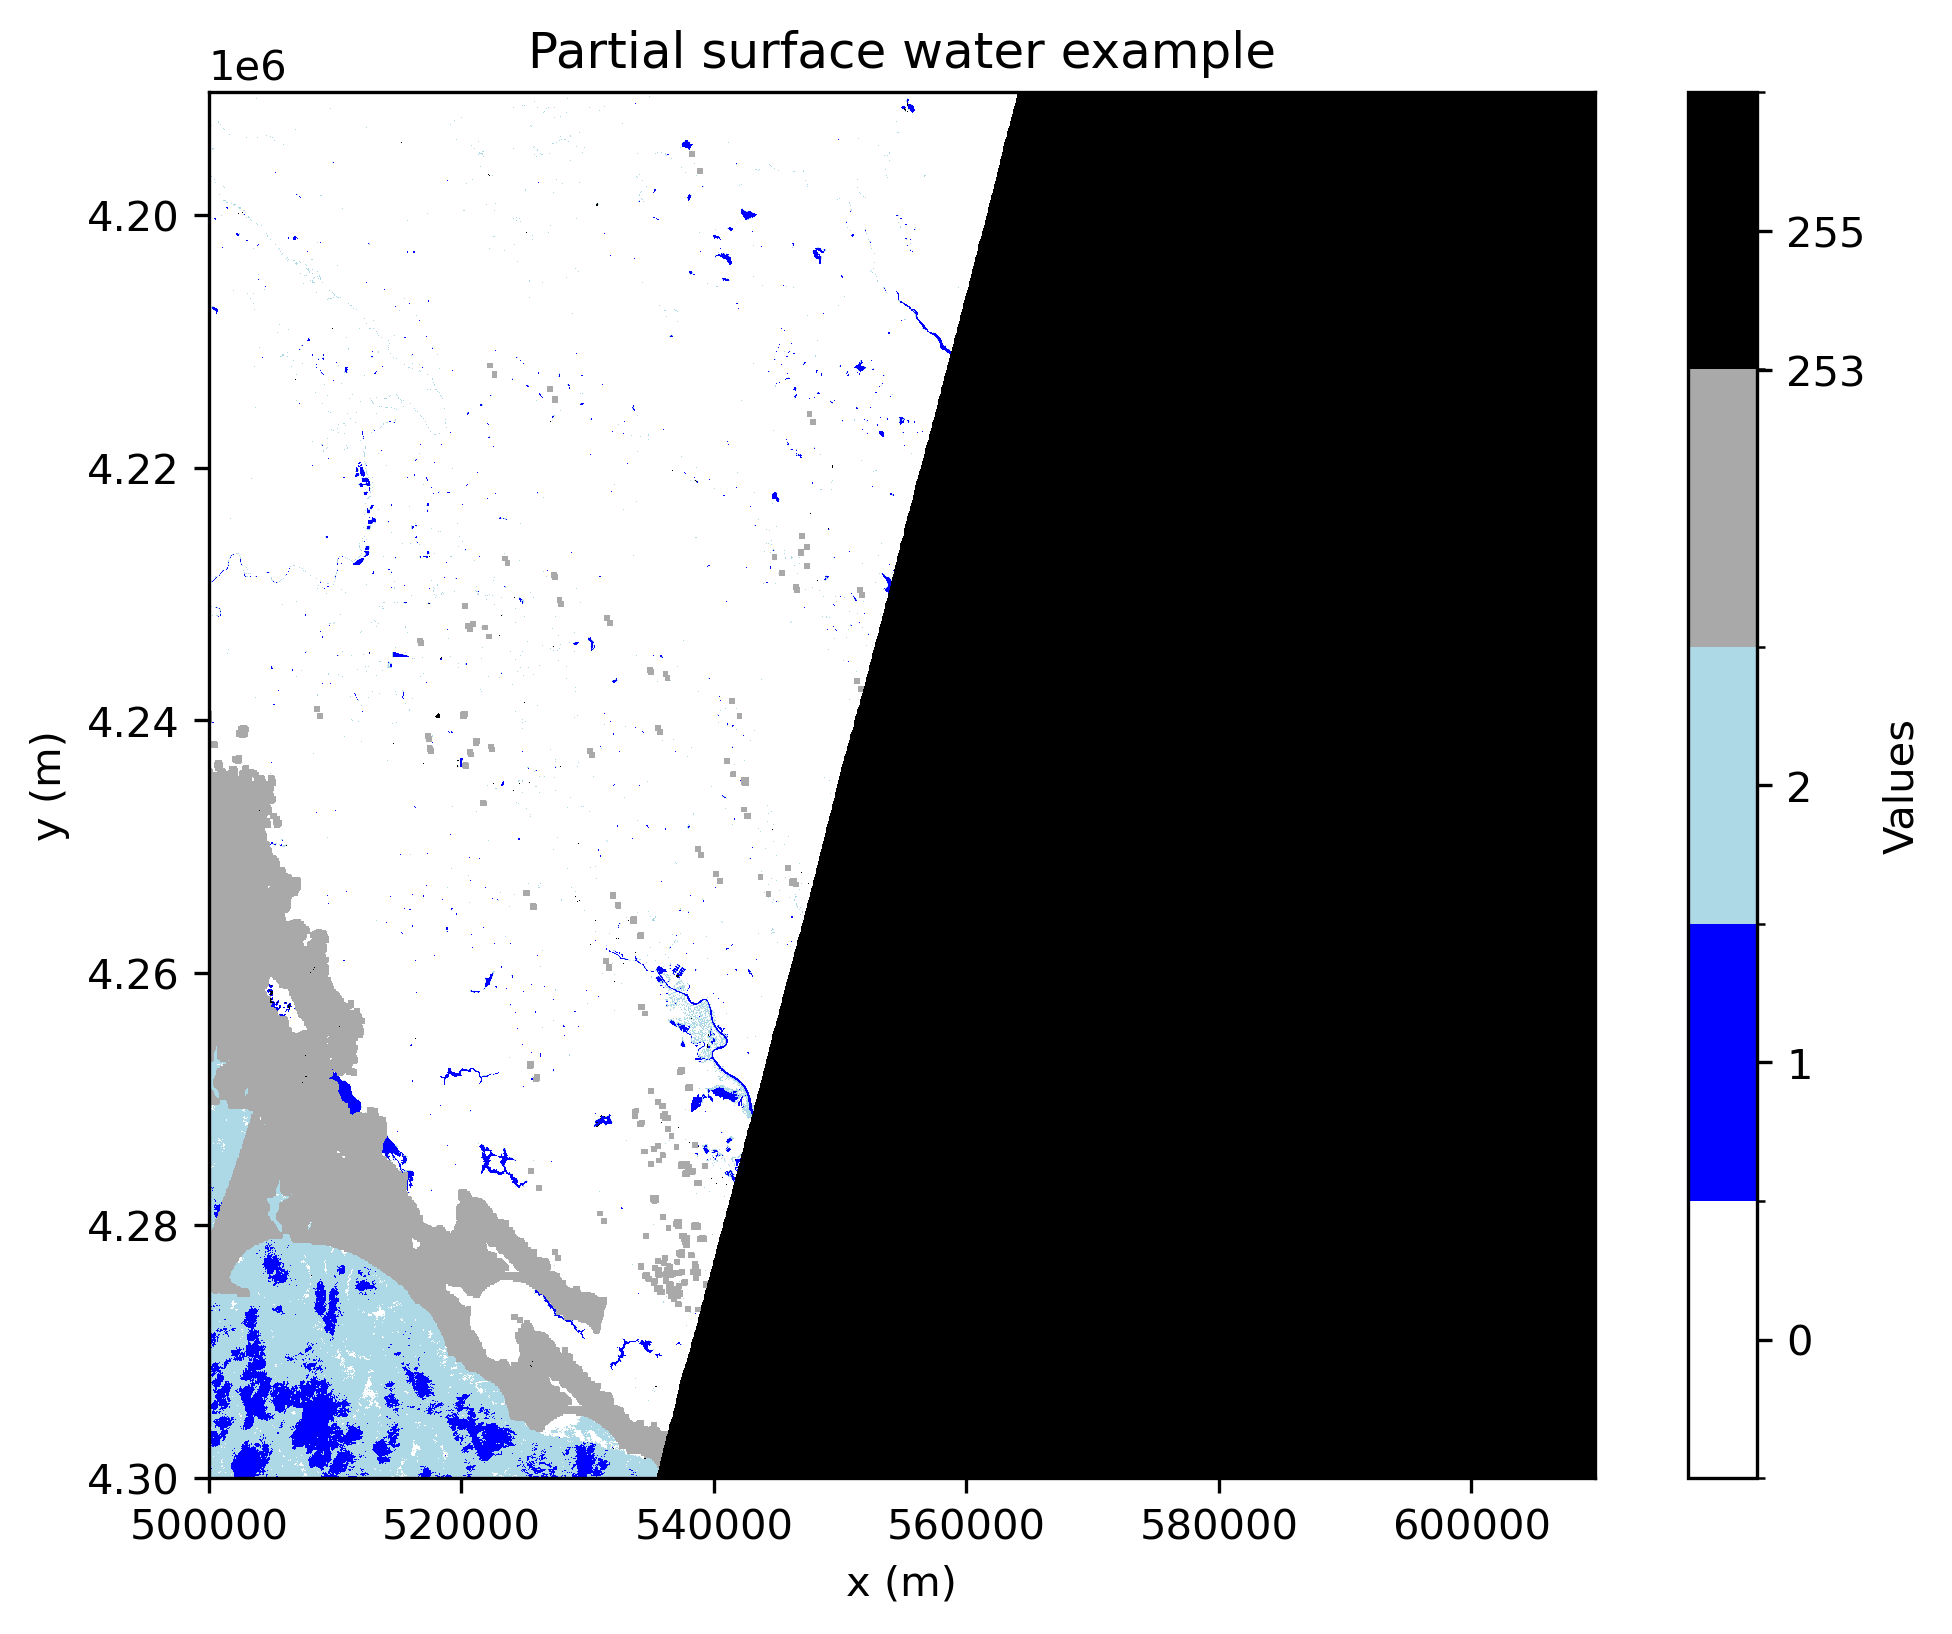

In [5]:
# HLS cmap before simplification
data_HLS_WTR[(data_HLS_WTR > 199) & (data_HLS_WTR != 253)] = 255  # (temporarily) regard data larger than 199 (except cloud) as no data

im = plt.figure()
im.set_dpi(300)
im.set_size_inches(8,6)
plt.imshow(data_HLS_WTR[:,:,23], cmap=HLS_compare_cmap, norm=HLS_compare_norm, interpolation='none', extent=[x[0], x[-1], y[0], y[-1]]) 
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('Partial surface water example')
#plt.clim(clim_uwr)
plt.colorbar(ticks=[0,1,2,253,255], label='Values')

In [6]:
# Simplify S1 data classes
data_S1_WTR[data_S1_WTR == 3] = 0  # (temporarily) regard inundated vegetation as not water
data_S1_WTR[data_S1_WTR > 199] = 255  # (temporarily) regard data larger than 200 as no data
# generate S1 water occurrence map
water_occurrence_map_S1_WTR = generate_water_occurrence_map(data_S1_WTR)

# Simplify HLS data classes
data_HLS_WTR[(data_HLS_WTR == 2) & (water_occurrence_map_S1_WTR[:,:,np.newaxis]==1)] = 1 # (temporarily) regard partial surface water as open water if open water in S1 data
data_HLS_WTR[data_HLS_WTR == 2] = 0  # (temporarily) regard remaining partial surface water as not water
data_HLS_WTR[(data_HLS_WTR > 199) & (data_HLS_WTR != 253)] = 255  # (temporarily) regard data larger than 199 (except cloud) as no data
# generate HLS water occurrence map
water_occurrence_map_HLS_WTR = generate_water_occurrence_map(data_HLS_WTR)

# Generate not water / open water masks
mask_HLS_WTR_not_water = water_occurrence_map_HLS_WTR == 0
mask_HLS_WTR_open_water = water_occurrence_map_HLS_WTR == 1
mask_S1_WTR_not_water = water_occurrence_map_S1_WTR == 0
mask_S1_WTR_open_water = water_occurrence_map_S1_WTR == 1

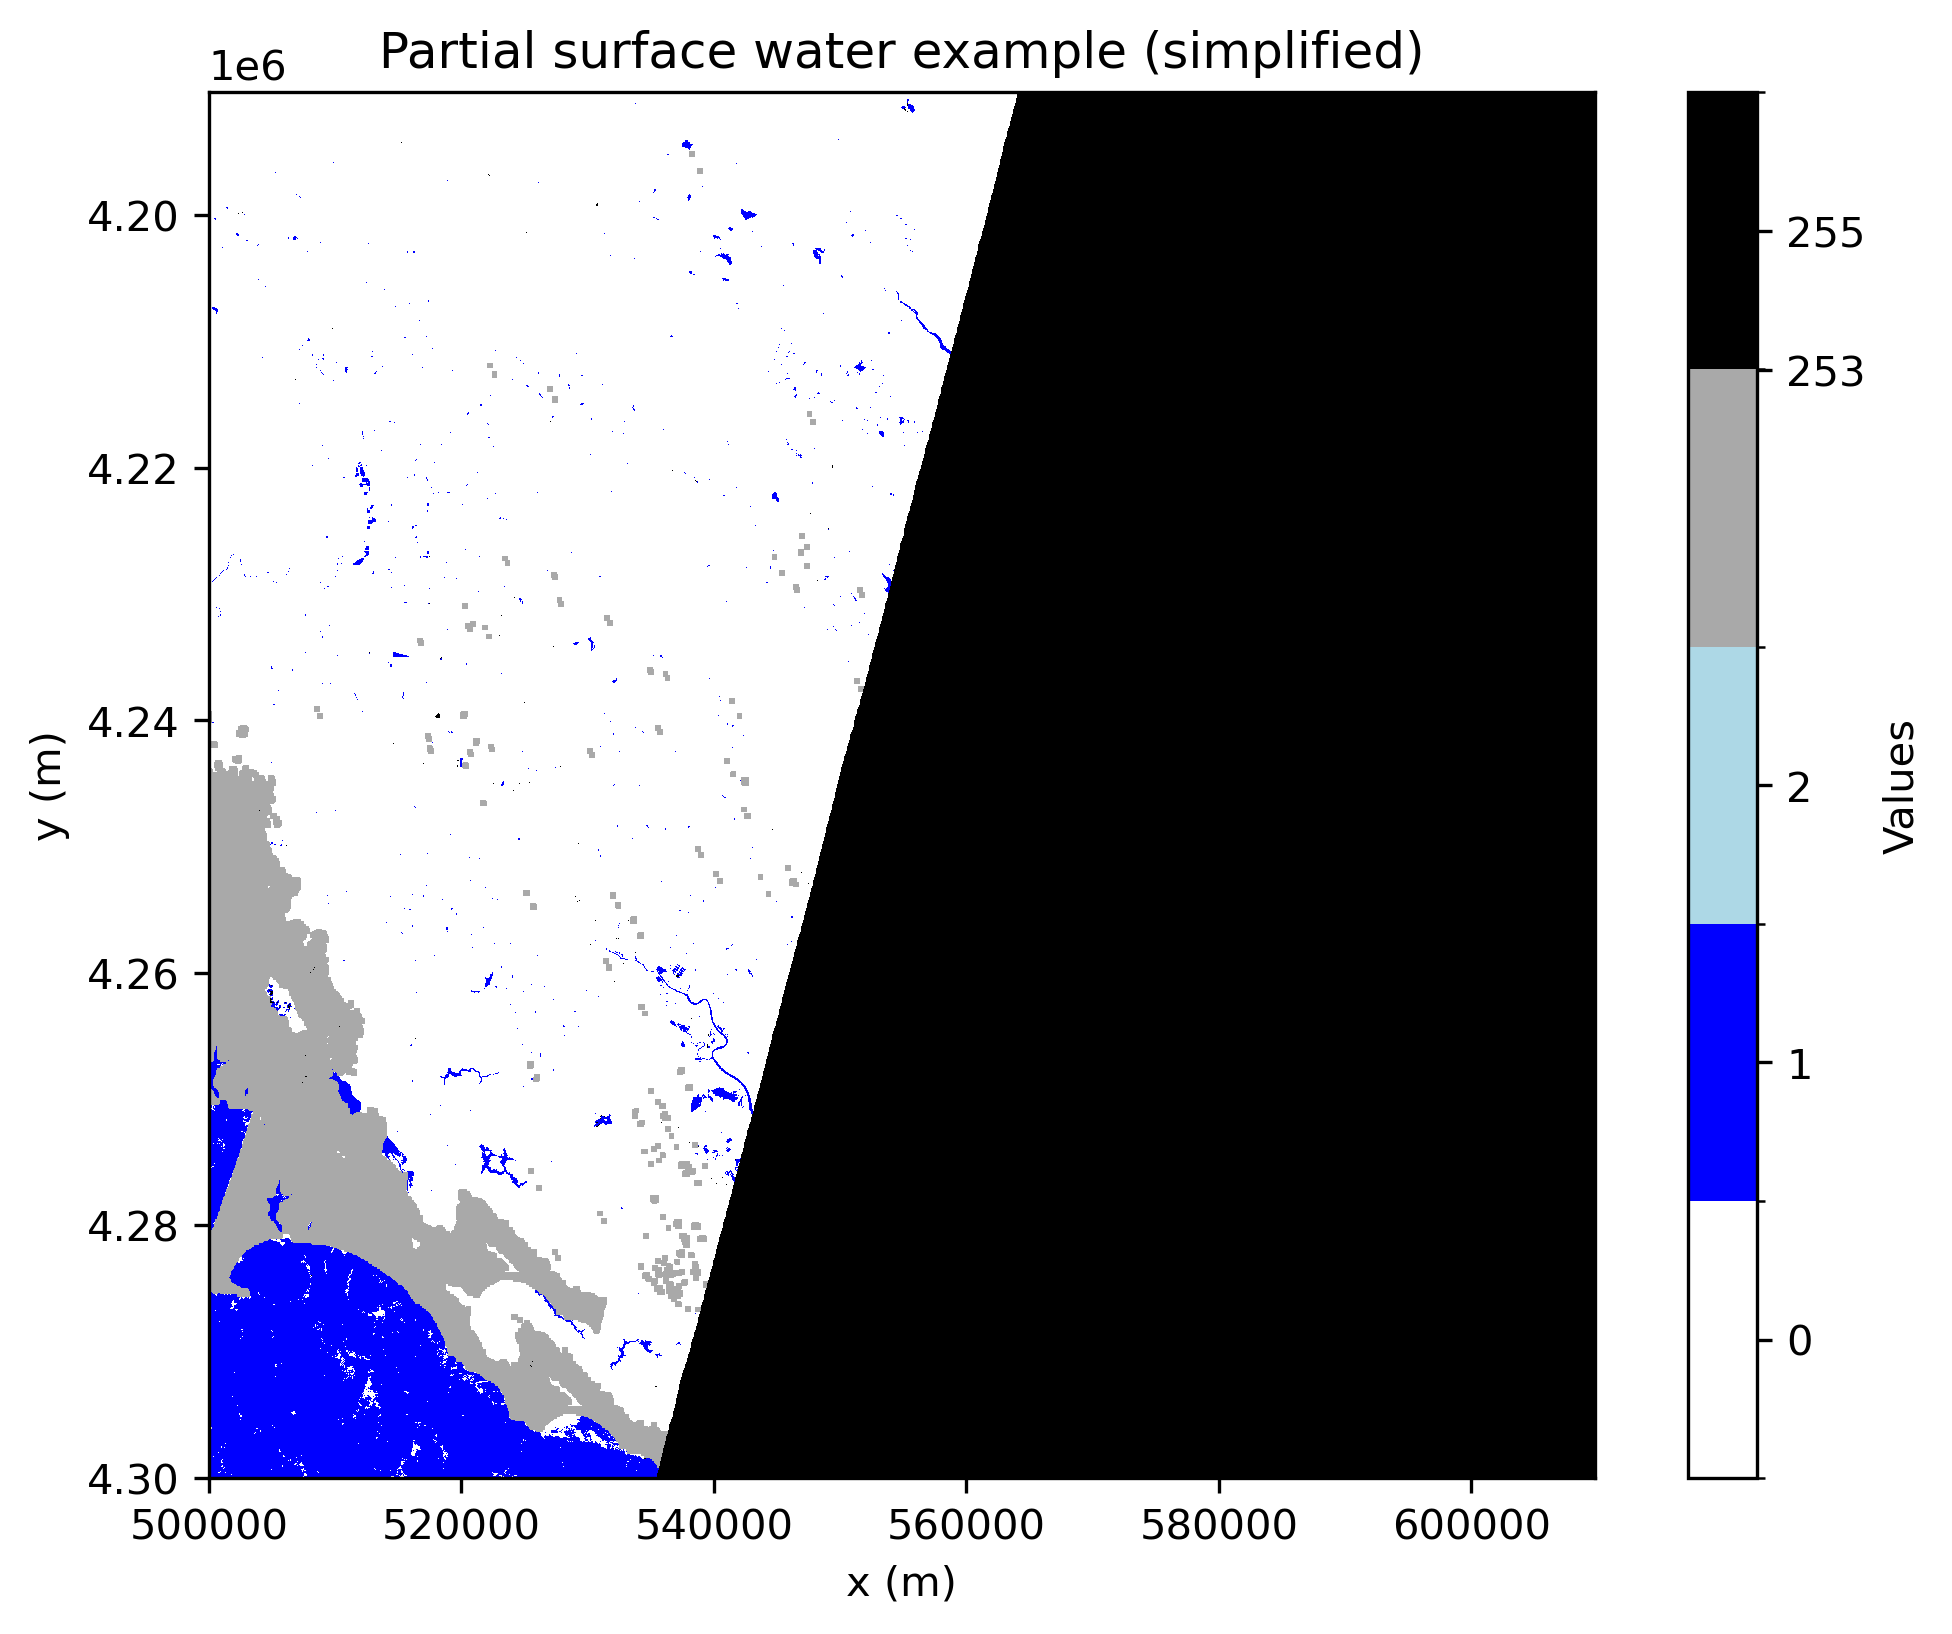

In [7]:
im = plt.figure()
im.set_dpi(300)
im.set_size_inches(8,6)
plt.imshow(data_HLS_WTR[:,:,23], cmap=HLS_compare_cmap, norm=HLS_compare_norm, interpolation='none', extent=[x[0], x[-1], y[0], y[-1]]) 
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('Partial surface water example (simplified)')
#plt.clim(clim_uwr)
plt.colorbar(ticks=[0, 1, 2, 253, 255], label='Values')

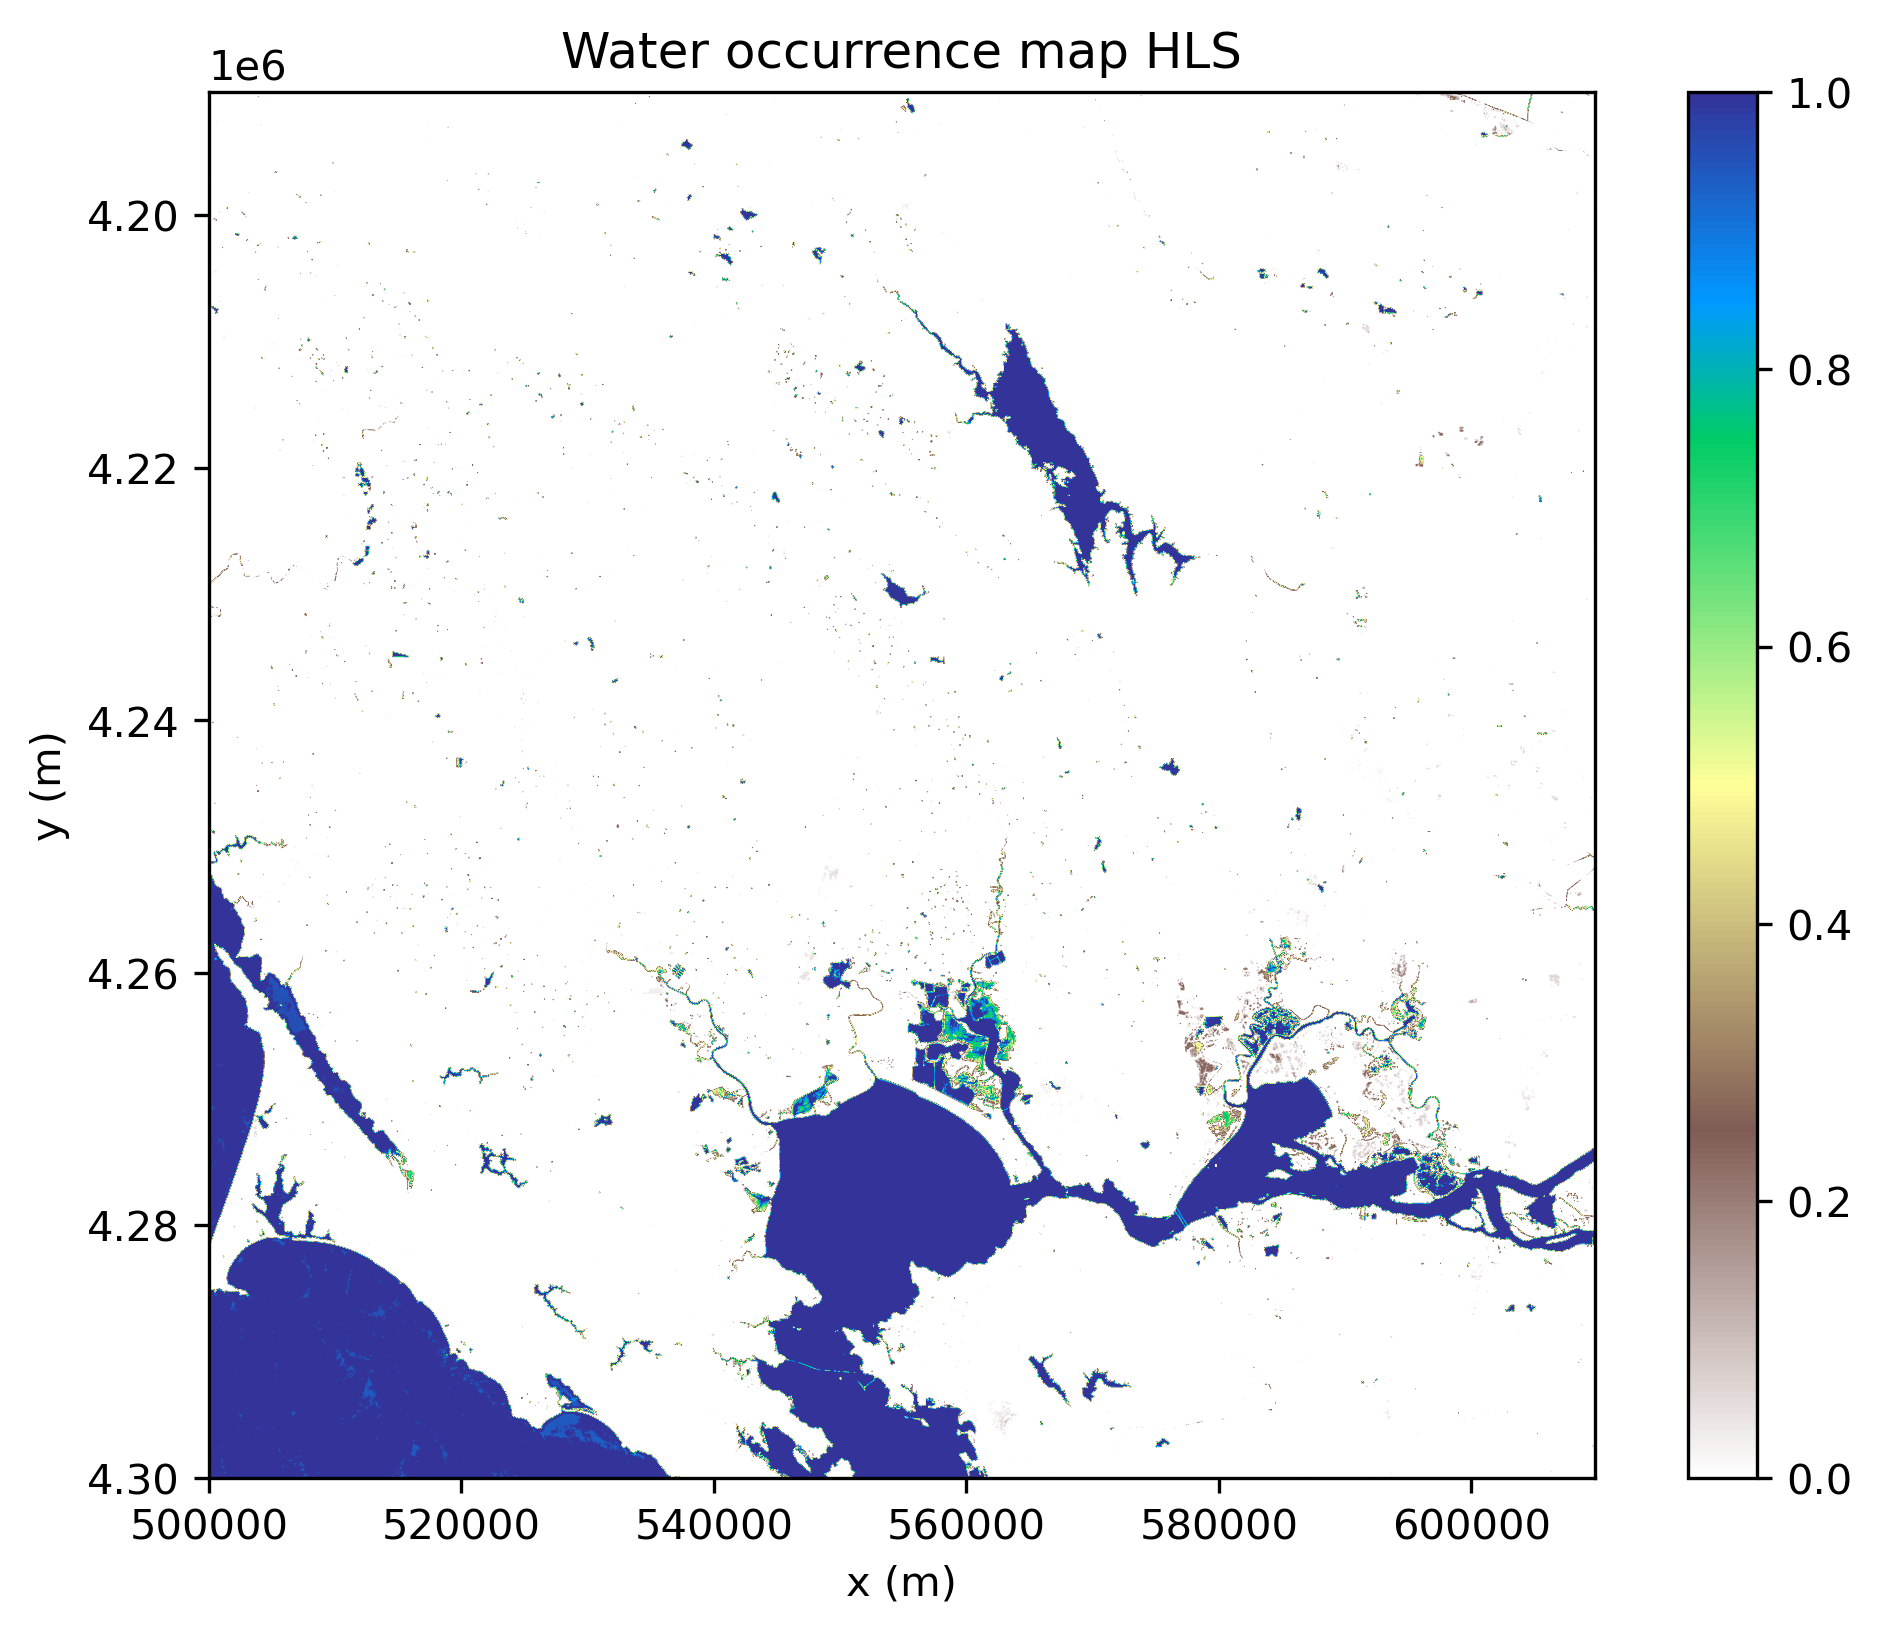

In [8]:
im = plt.figure()
im.set_dpi(300)
im.set_size_inches(8,6)
plt.imshow(water_occurrence_map_HLS_WTR, cmap='terrain_r', extent=[x[0], x[-1], y[0], y[-1]]) 
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('Water occurrence map HLS')
#plt.clim(clim_uwr)
plt.colorbar()



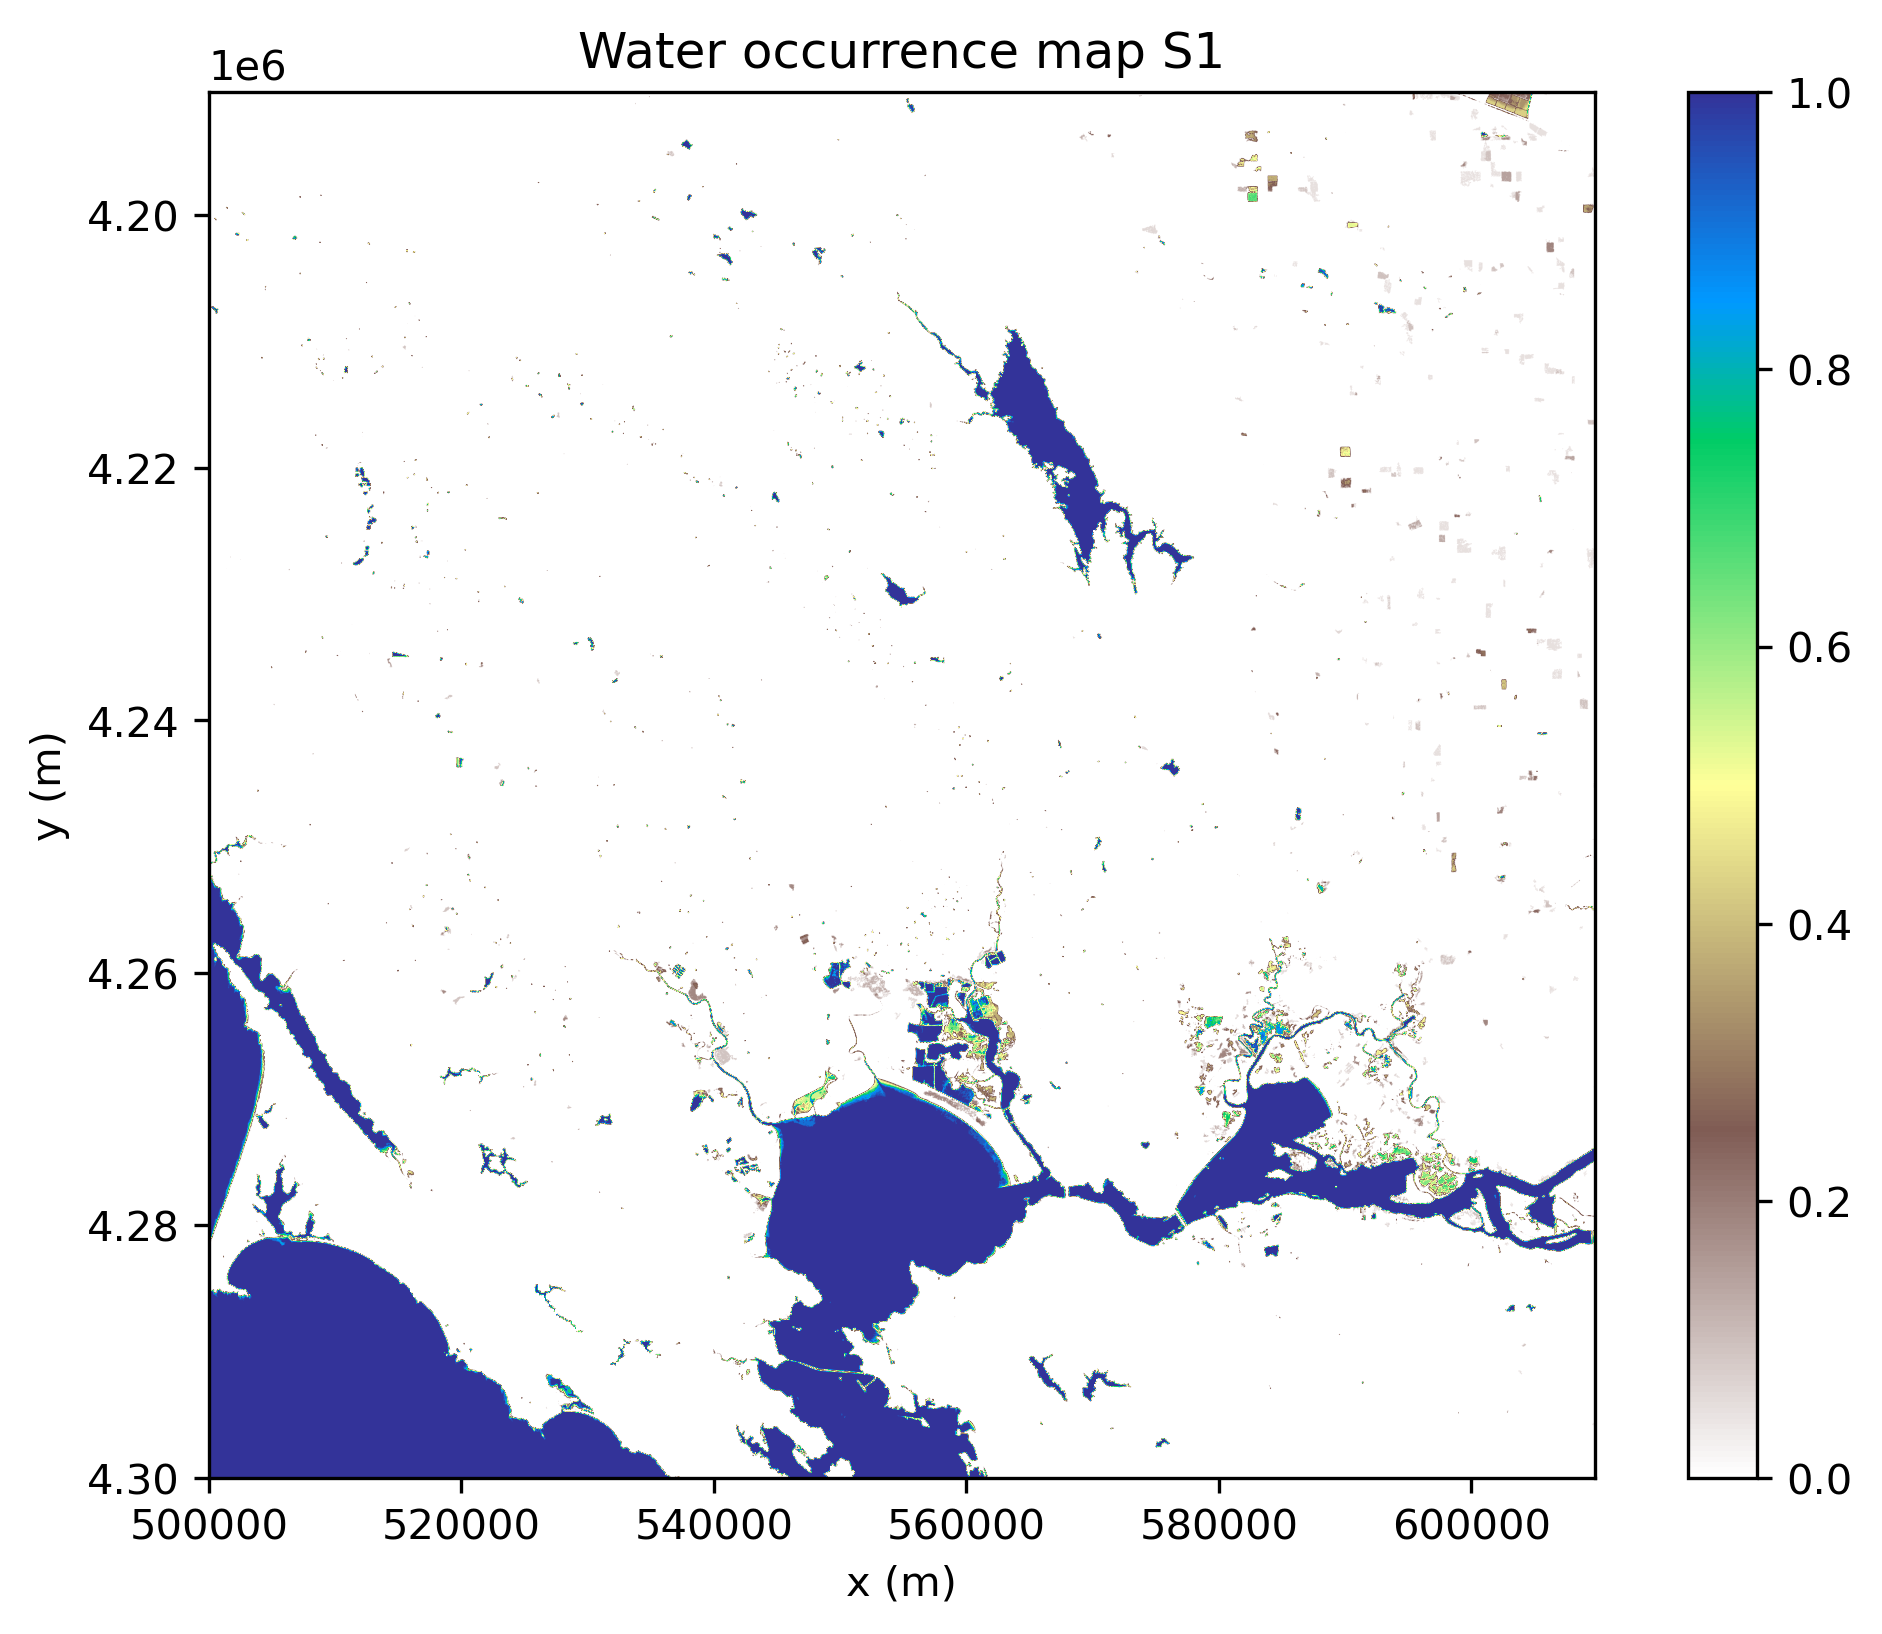

In [9]:

im = plt.figure()
im.set_dpi(300)
im.set_size_inches(8,6)
plt.imshow(water_occurrence_map_S1_WTR, cmap='terrain_r', extent=[x[0], x[-1], y[0], y[-1]]) 
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('Water occurrence map S1')
#plt.clim(clim_uwr)
plt.colorbar()


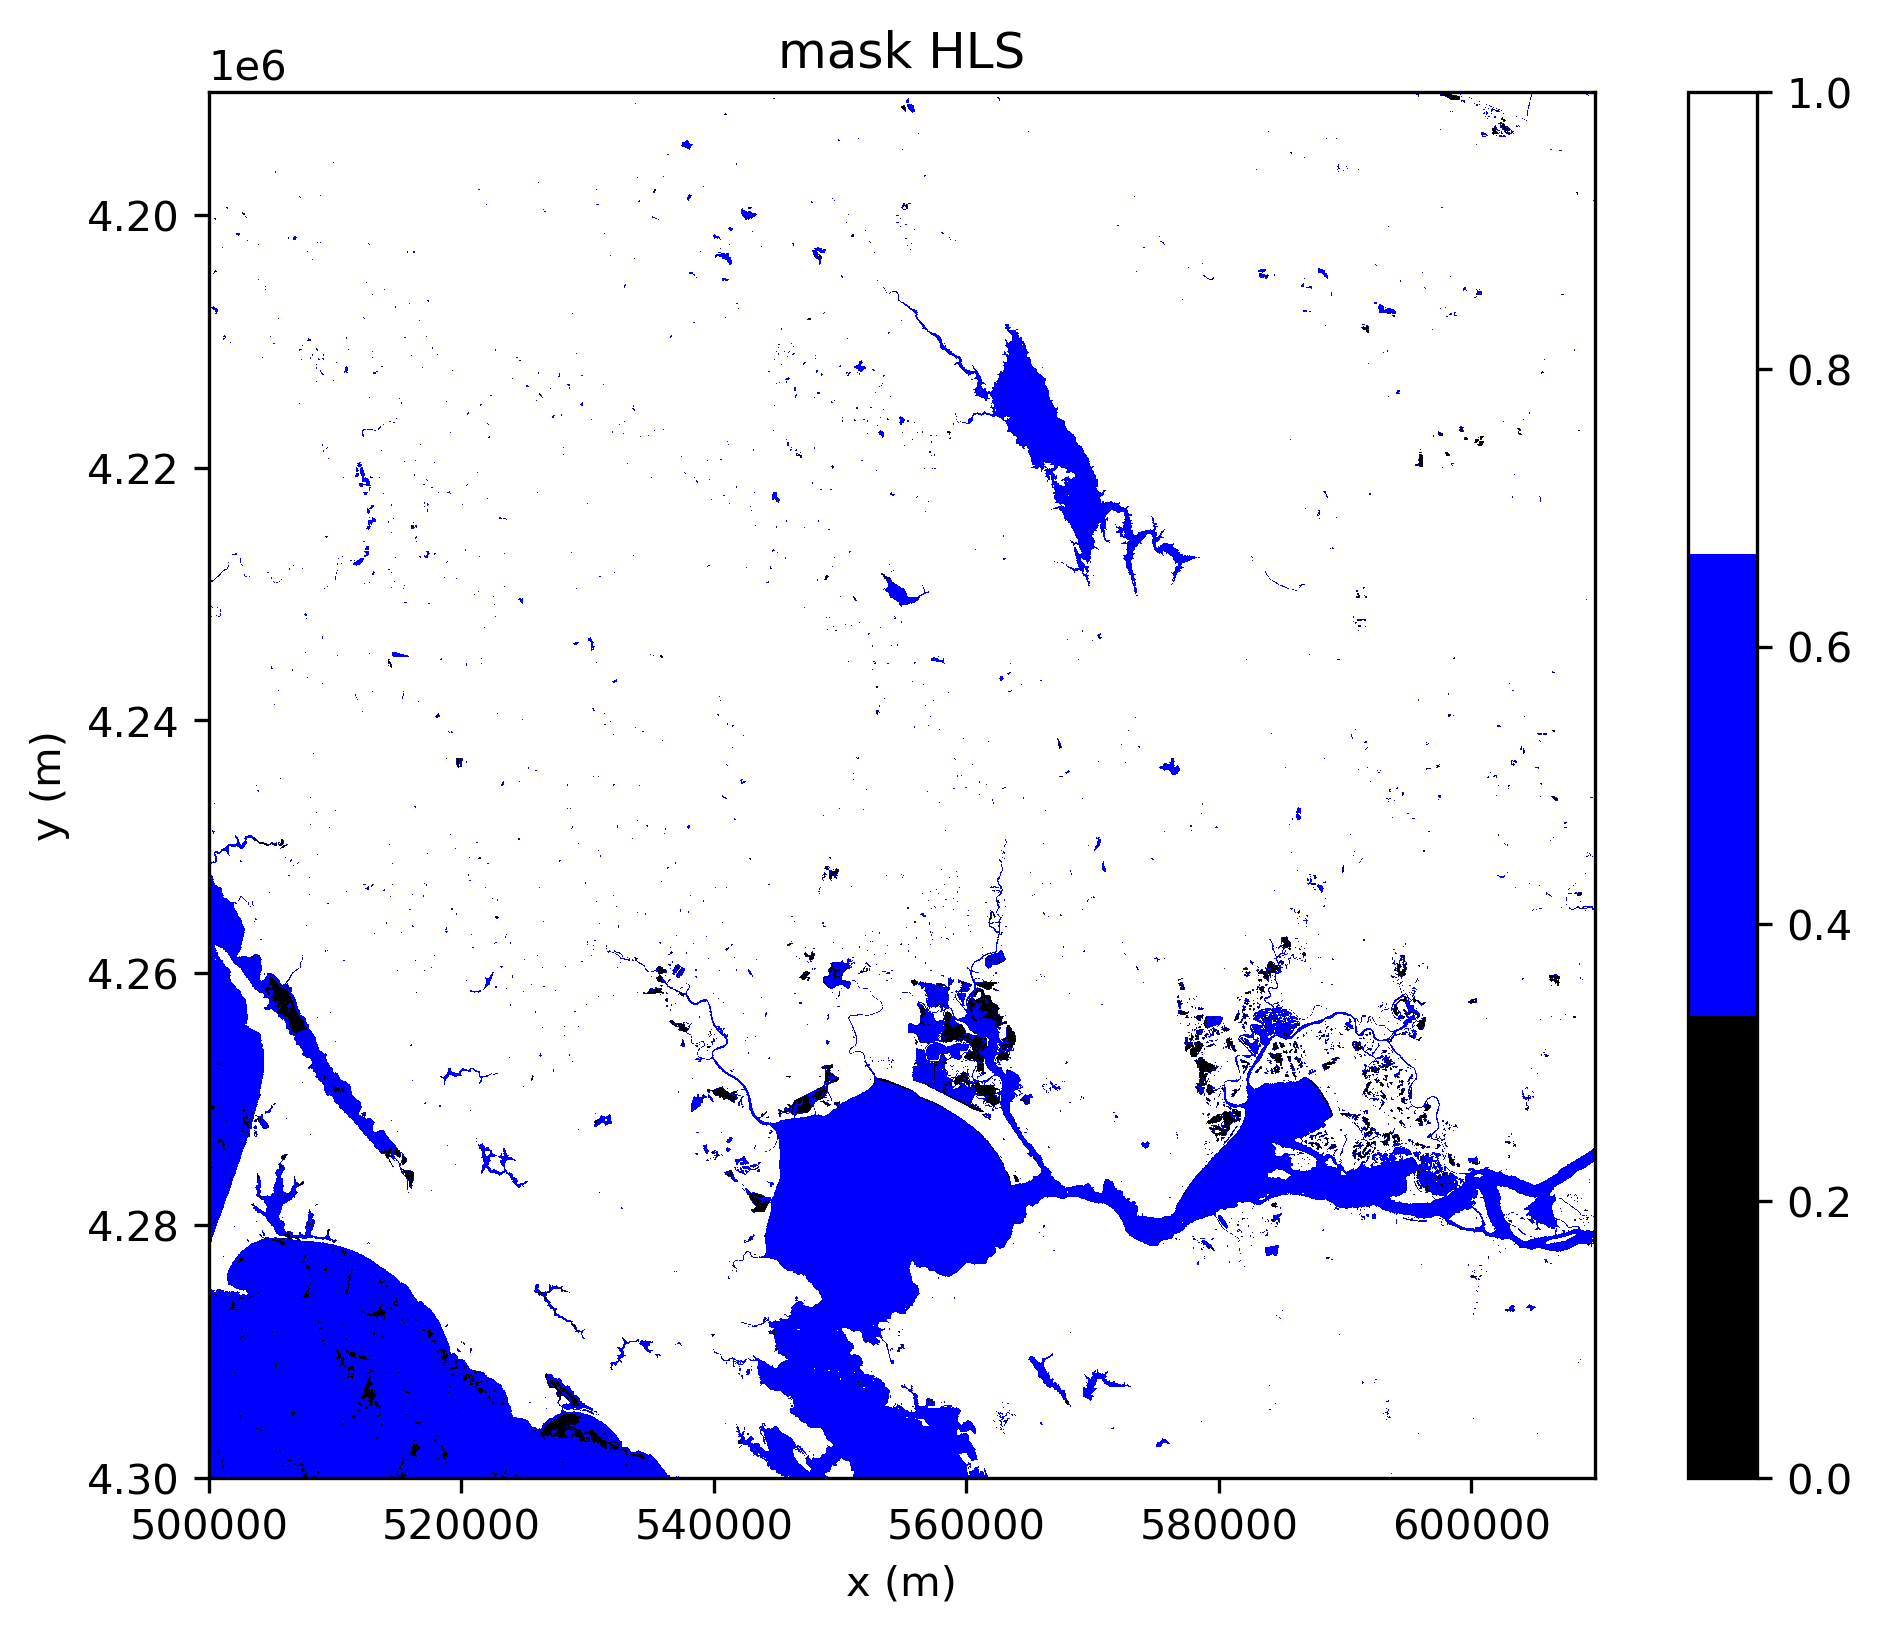

In [44]:
mask_HLS = mask_HLS_WTR_open_water * 0.5 + mask_HLS_WTR_not_water

#clim_uwr = [-(abs(np.min(unw_ifg)) - (abs(np.min(unw_ifg))%5)), np.max(unw_ifg) - (np.max(unw_ifg) % 5)]
im = plt.figure()
im.set_dpi(300)
im.set_size_inches(8,6)
plt.imshow(mask_HLS, cmap=black_blue_white, interpolation='none', extent=[x[0], x[-1], y[0], y[-1]]) 
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('mask HLS')
plt.clim([0,1])
plt.colorbar()

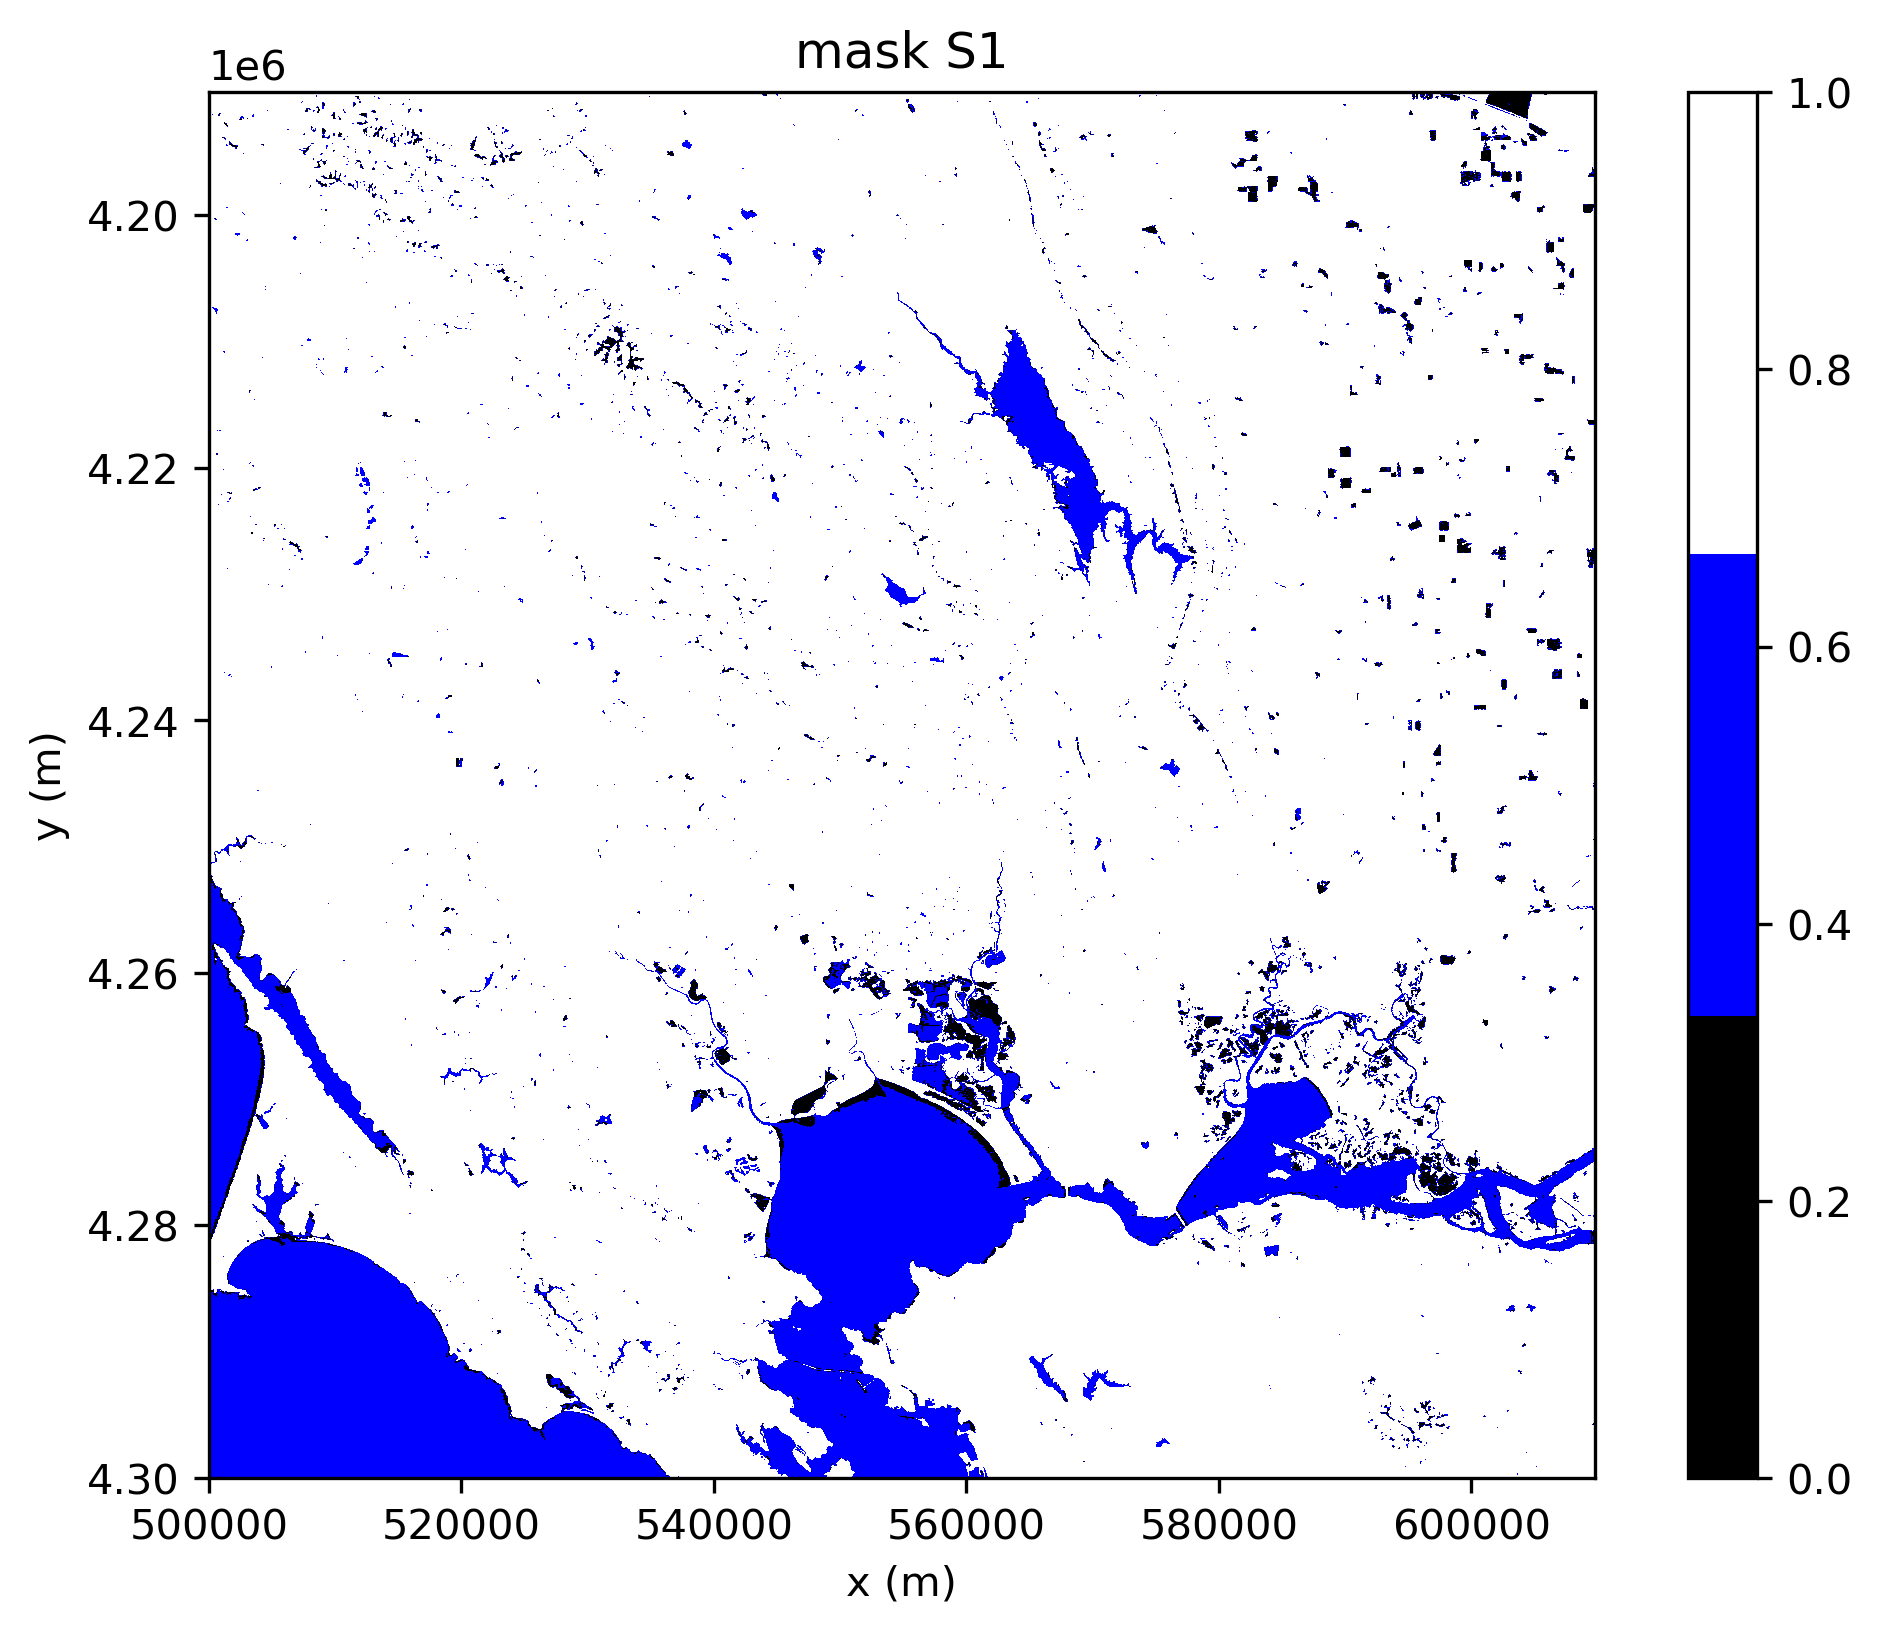

In [45]:
mask_S1 = mask_S1_WTR_open_water * 0.5 + mask_S1_WTR_not_water

#clim_uwr = [-(abs(np.min(unw_ifg)) - (abs(np.min(unw_ifg))%5)), np.max(unw_ifg) - (np.max(unw_ifg) % 5)]
im = plt.figure()
im.set_dpi(300)
im.set_size_inches(8,6)
plt.imshow(mask_S1, cmap=black_blue_white, interpolation='none', extent=[x[0], x[-1], y[0], y[-1]]) 
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('mask S1')
plt.clim([0,1])
plt.colorbar()

#### Below cloud filling process is referring to 
__https://www.sciencedirect.com/science/article/abs/pii/S0022169422013610__
#### Naive Bayes classification-based surface water gap-filling from partially contaminated optical remote sensing image

In [10]:
# Pixels with 0 < probability < 1 to be used for features
mask_features_HLS = (water_occurrence_map_HLS_WTR > 0) & (water_occurrence_map_HLS_WTR < 1)
mask_features_S1 = (water_occurrence_map_S1_WTR > 0) & (water_occurrence_map_S1_WTR < 1)

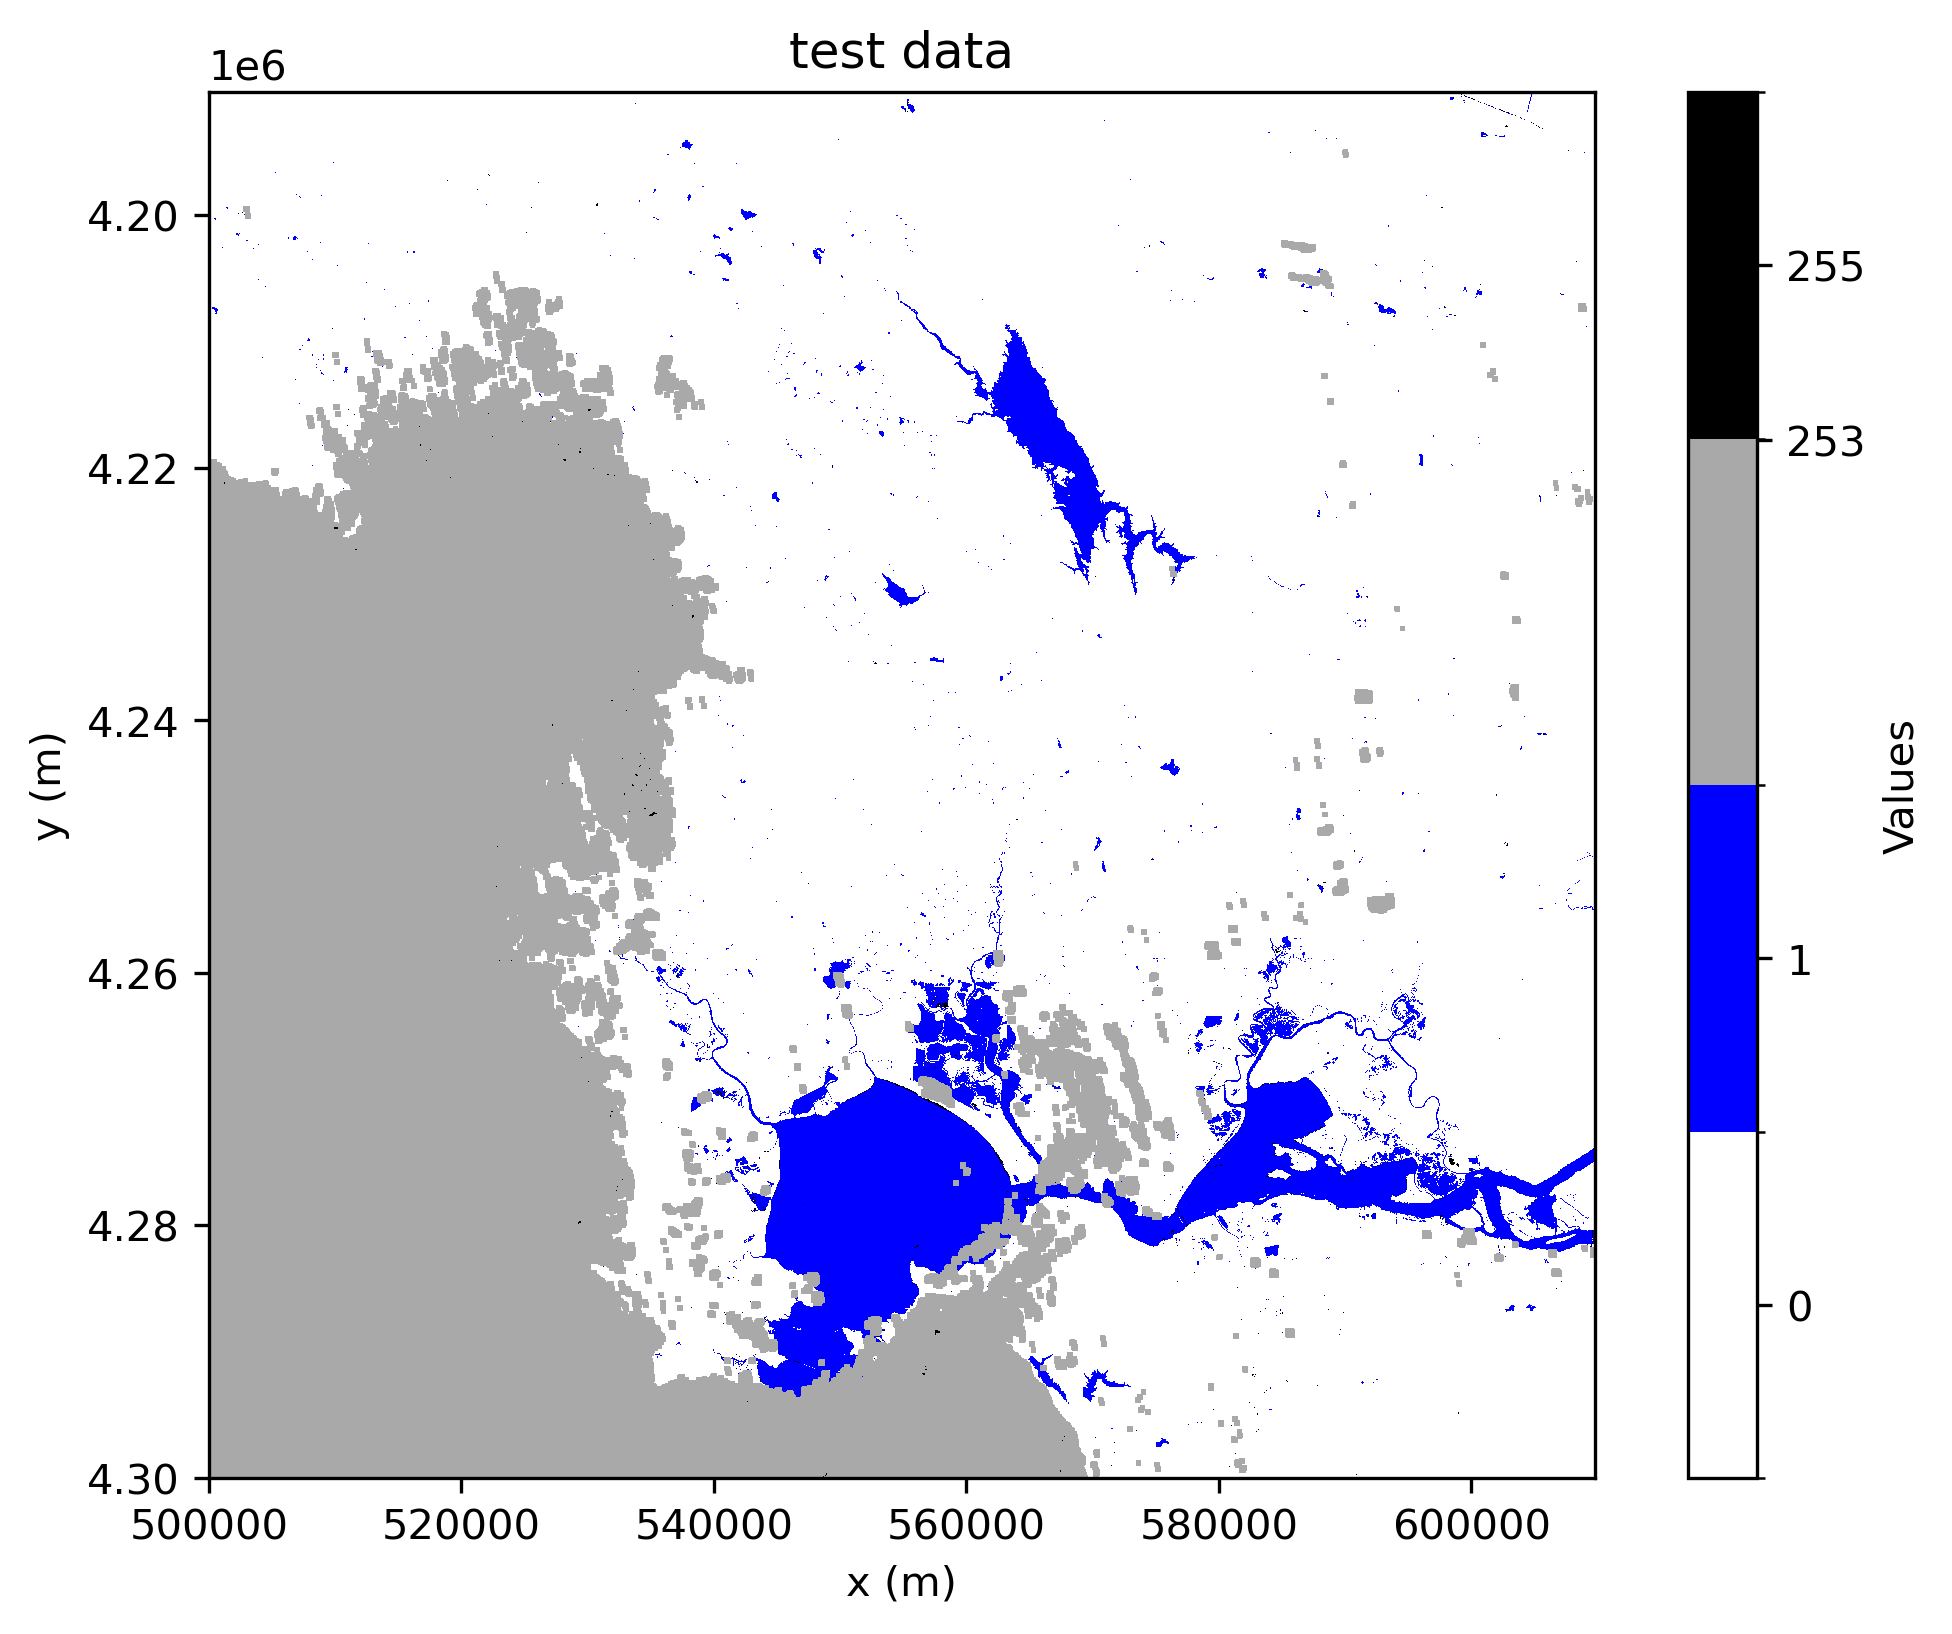

In [40]:
# Load an HLS data as test data to fill
fp = "/u/aurora-r0/jeon/tools/DSWx-fusion/DSWx-Enhanced-Analysis/download_10SEH/"

#test_fp = "OPERA_L3_DSWx-HLS_T10SEH_20241010T185311Z_20241012T203426Z_S2A_30_v1.0_B01_WTR"
#test_fp = "OPERA_L3_DSWx-HLS_T10SEH_20240910T184931Z_20240912T225222Z_S2A_30_v1.0_B01_WTR"
#test_fp = "OPERA_L3_DSWx-HLS_T10SEH_20240920T185051Z_20240924T221601Z_S2A_30_v1.0_B01_WTR"
test_fp = "OPERA_L3_DSWx-HLS_T10SEH_20240925T185039Z_20241001T042212Z_S2B_30_v1.0_B01_WTR"

test_data, x, y = gdal_load(fp + test_fp + ".tif", 1)

# Simplify test data in the same way
test_data[(test_data == 2) & (water_occurrence_map_S1_WTR == 1)] = 0  # (temporarily) regard partial surface water as open water if open water in S1 data
test_data[test_data == 2] = 0  # (temporarily) regard partial surface water as not water
test_data[(test_data > 199) & (test_data != 253)] = 255  # (temporarily) regard data larger than 199 as no data

# Feature pixels (xi): clear(not cloud, not nonvalid) pixels in test data to be filled
mask_features_test = mask_features_HLS & (test_data != 253) & (test_data != 255) # clear pixel in test data & 0 < prop <1
#idx_features_test = np.argwhere(mask_features_test) 


im = plt.figure()
im.set_dpi(300)
im.set_size_inches(8,6)
plt.imshow(test_data, cmap=HLS_cmap, norm=HLS_norm, interpolation='none', extent=[x[0], x[-1], y[0], y[-1]]) 
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('test data')
#plt.clim(clim_uwr)
plt.colorbar(ticks=[0, 1, 253, 255], label='Values')

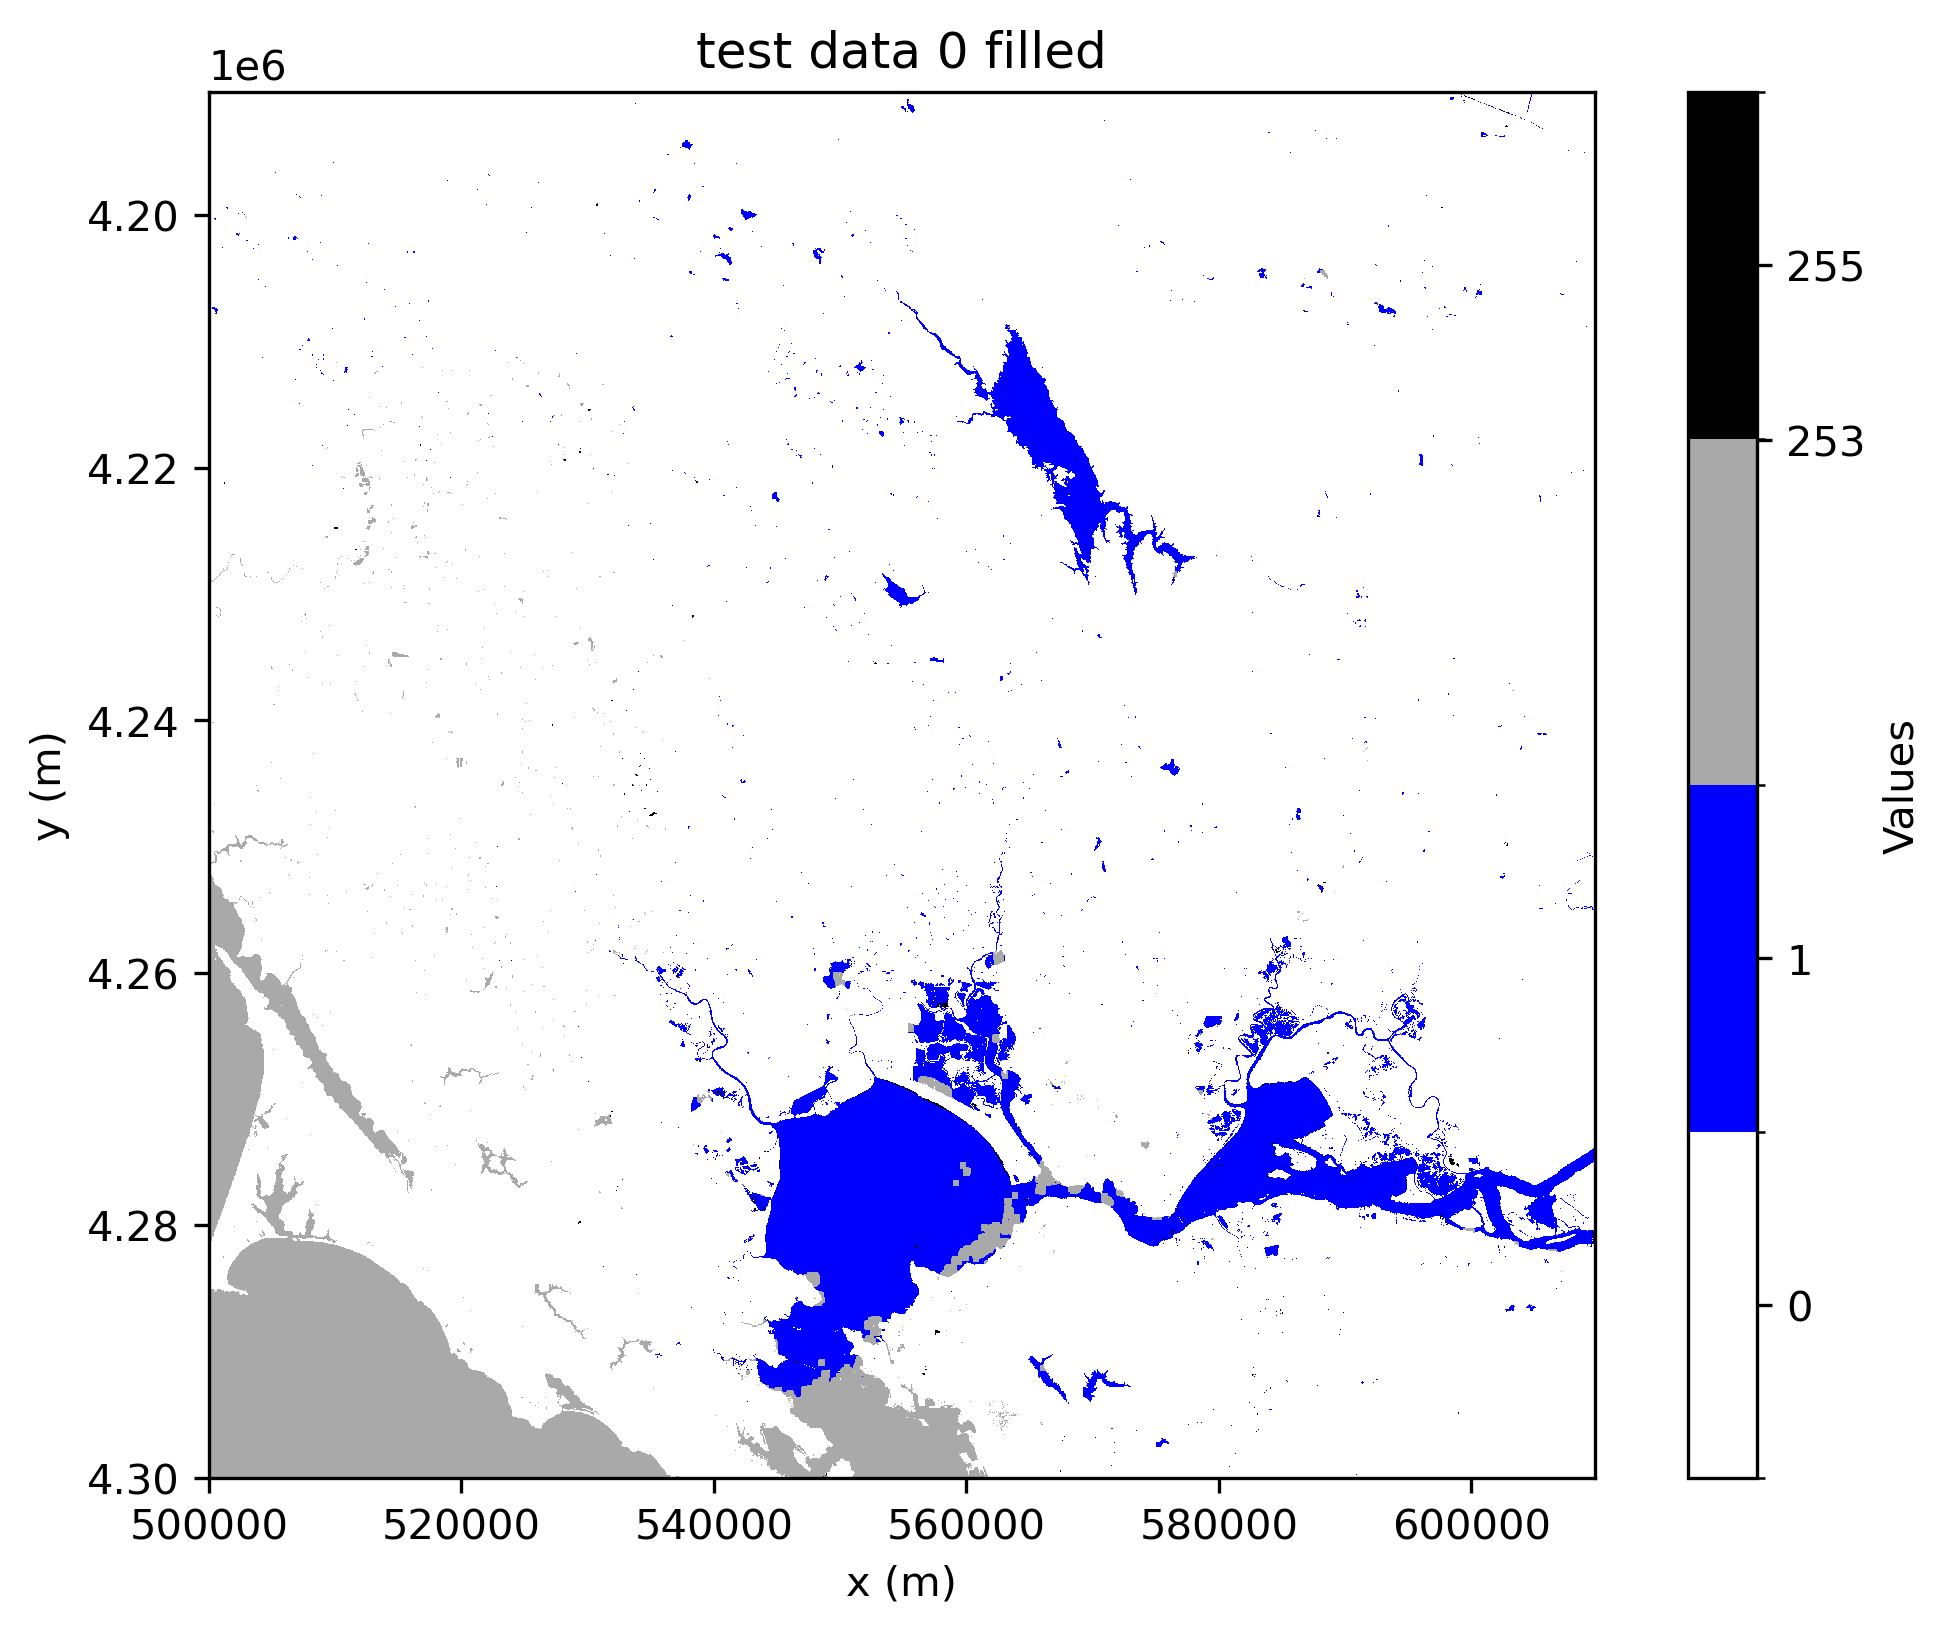

In [41]:
fill_data = np.copy(test_data)
fill_data[(fill_data == 253) & mask_HLS_WTR_not_water] = 0

im = plt.figure()
im.set_dpi(300)
im.set_size_inches(8,6)
plt.imshow(fill_data, cmap=HLS_cmap, norm=HLS_norm, interpolation='none', extent=[x[0], x[-1], y[0], y[-1]]) 
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('test data 0 filled')
#plt.clim(clim_uwr)
plt.colorbar(ticks=[0, 1, 253, 255], label='Values')

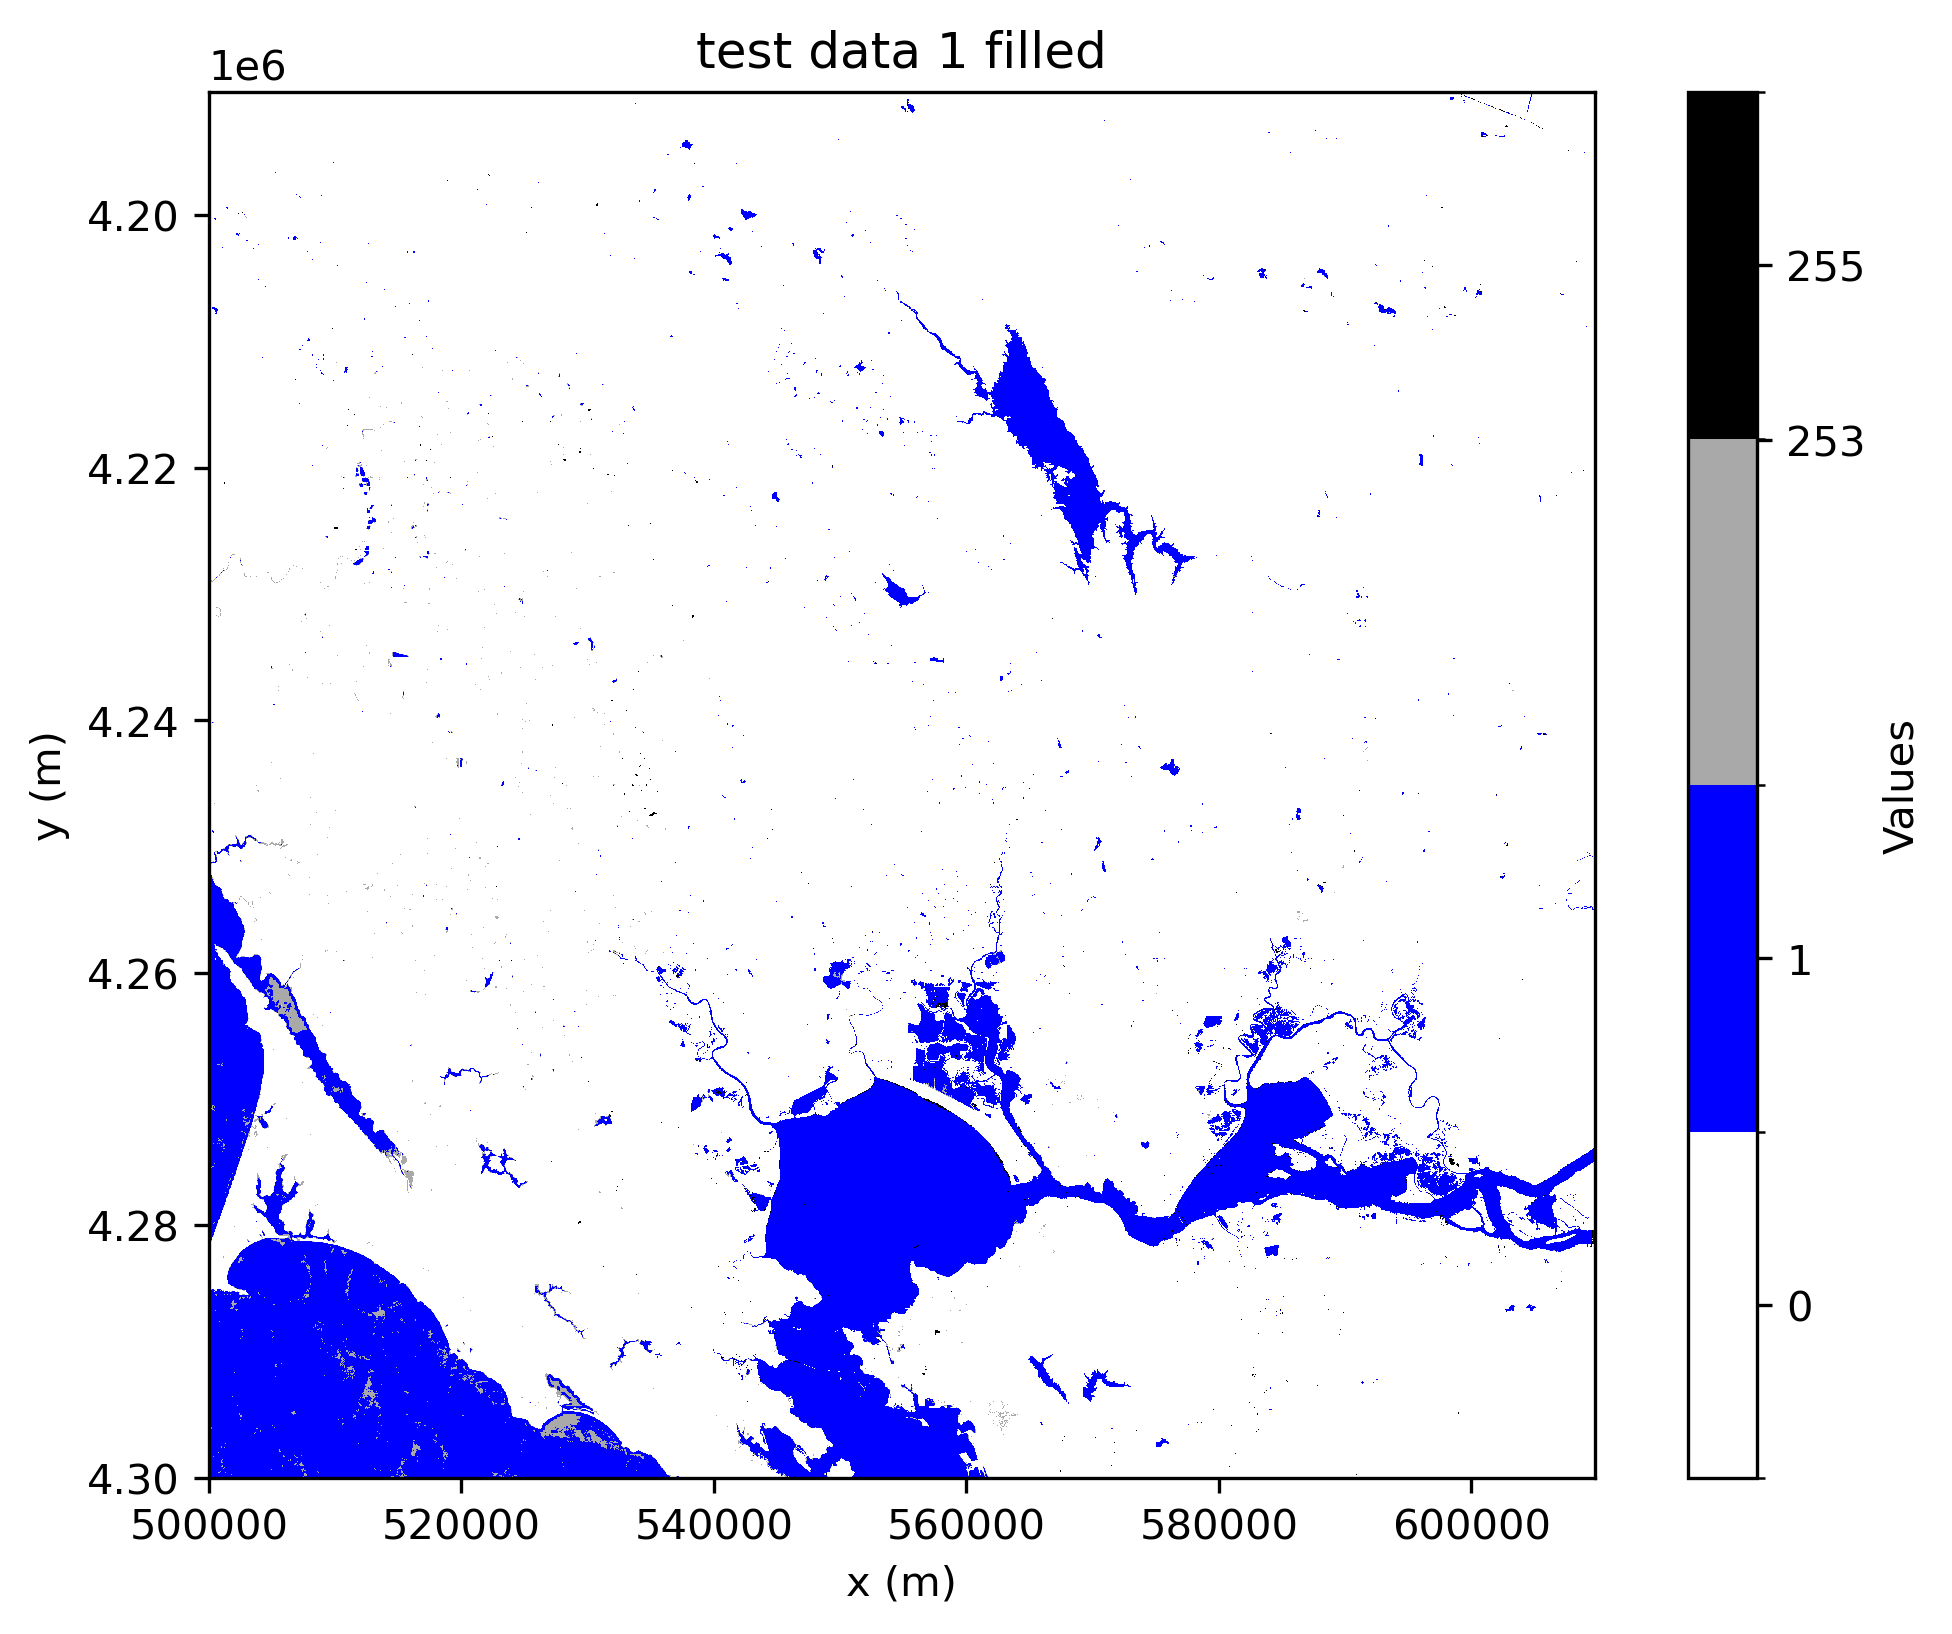

In [42]:
fill_data[(fill_data == 253) & mask_HLS_WTR_open_water] = 1

im = plt.figure()
im.set_dpi(300)
im.set_size_inches(8,6)
plt.imshow(fill_data, cmap=HLS_cmap, norm=HLS_norm, interpolation='none', extent=[x[0], x[-1], y[0], y[-1]]) 
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('test data 1 filled')
#plt.clim(clim_uwr)
plt.colorbar(ticks=[0, 1, 253, 255], label='Values')

In [43]:
# only interested pixels in data_HLS_WTR are mask_test_features.
features_data_HLS_WTR = data_HLS_WTR[mask_features_test,:] # 2d array(# feature pixels, N)
features_test_data = test_data[mask_features_test] # 1d array (# feature pixels,)

# test_pixel_occurrence = data_HLS_WTR == test_data[:,:,np.newaxis]
test_pixel_occurrence = features_data_HLS_WTR == features_test_data[:,np.newaxis]
# mask_valid_pixels = (data_HLS_WTR == 0) | (data_HLS_WTR == 1) # valid pixels excluding clouds and nodata
mask_valid_pixels = (features_data_HLS_WTR == 0) | (features_data_HLS_WTR == 1) # valid pixels excluding clouds and nodata


def get_p_xi(y, data_HLS_WTR, mask_valid_pixels, test_pixel_occurrence):

    idx_layer_y = np.atleast_1d(np.squeeze(np.argwhere(data_HLS_WTR[idx[0], idx[1], :] == y))) # idx of layers that gap pixel had value y (y=0 or y=1)
    count_Y = np.sum(mask_valid_pixels[:,idx_layer_y], axis = -1) # num of valid layers for each pixels excluding cloud and nonvalid
    count_xi = np.sum(test_pixel_occurrence[:,idx_layer_y], axis = -1) # count pixels that had same values as xi in those layers
    
    # P(xi|Y)
    p_xi = count_xi / count_Y
    p_xi[p_xi == 0] = 1 / data_HLS_WTR.shape[2] # Exception handling Eq. 8 in paper

    return p_xi

idx_fill_test = np.argwhere(fill_data == 253) # indices of pixels to be filled
final_data = np.copy(fill_data)

for idx in idx_fill_test:

    # exception case
    if np.isnan(water_occurrence_map_HLS_WTR[tuple(idx)]): # When all history values were 255
        final_data[tuple(idx)] = 255
        continue

    # P(Y)
    p_y_1 = water_occurrence_map_HLS_WTR[tuple(idx)] # P(y=1)
    p_y_0 = 1 - p_y_1 # P(y=0)

    # P(xi|y=0)
    p_xi_0 = get_p_xi(0, data_HLS_WTR, mask_valid_pixels, test_pixel_occurrence)

    # P(xi|y=1)
    p_xi_1 = get_p_xi(1, data_HLS_WTR, mask_valid_pixels, test_pixel_occurrence)

    y_0 = np.log(p_y_0) + np.sum(np.log(p_xi_0[(~np.isnan(p_xi_0)) & (~np.isnan(p_xi_1))]))
    y_1 = np.log(p_y_1) + np.sum(np.log(p_xi_1[(~np.isnan(p_xi_0)) & (~np.isnan(p_xi_1))]))

    if y_0 > y_1:
        final_data[tuple(idx)] = 0
    else:
        final_data[tuple(idx)] = 1



/tmp/ipykernel_150819/2492507407.py:18: RuntimeWarning: invalid value encountered in divide
  p_xi = count_xi / count_Y


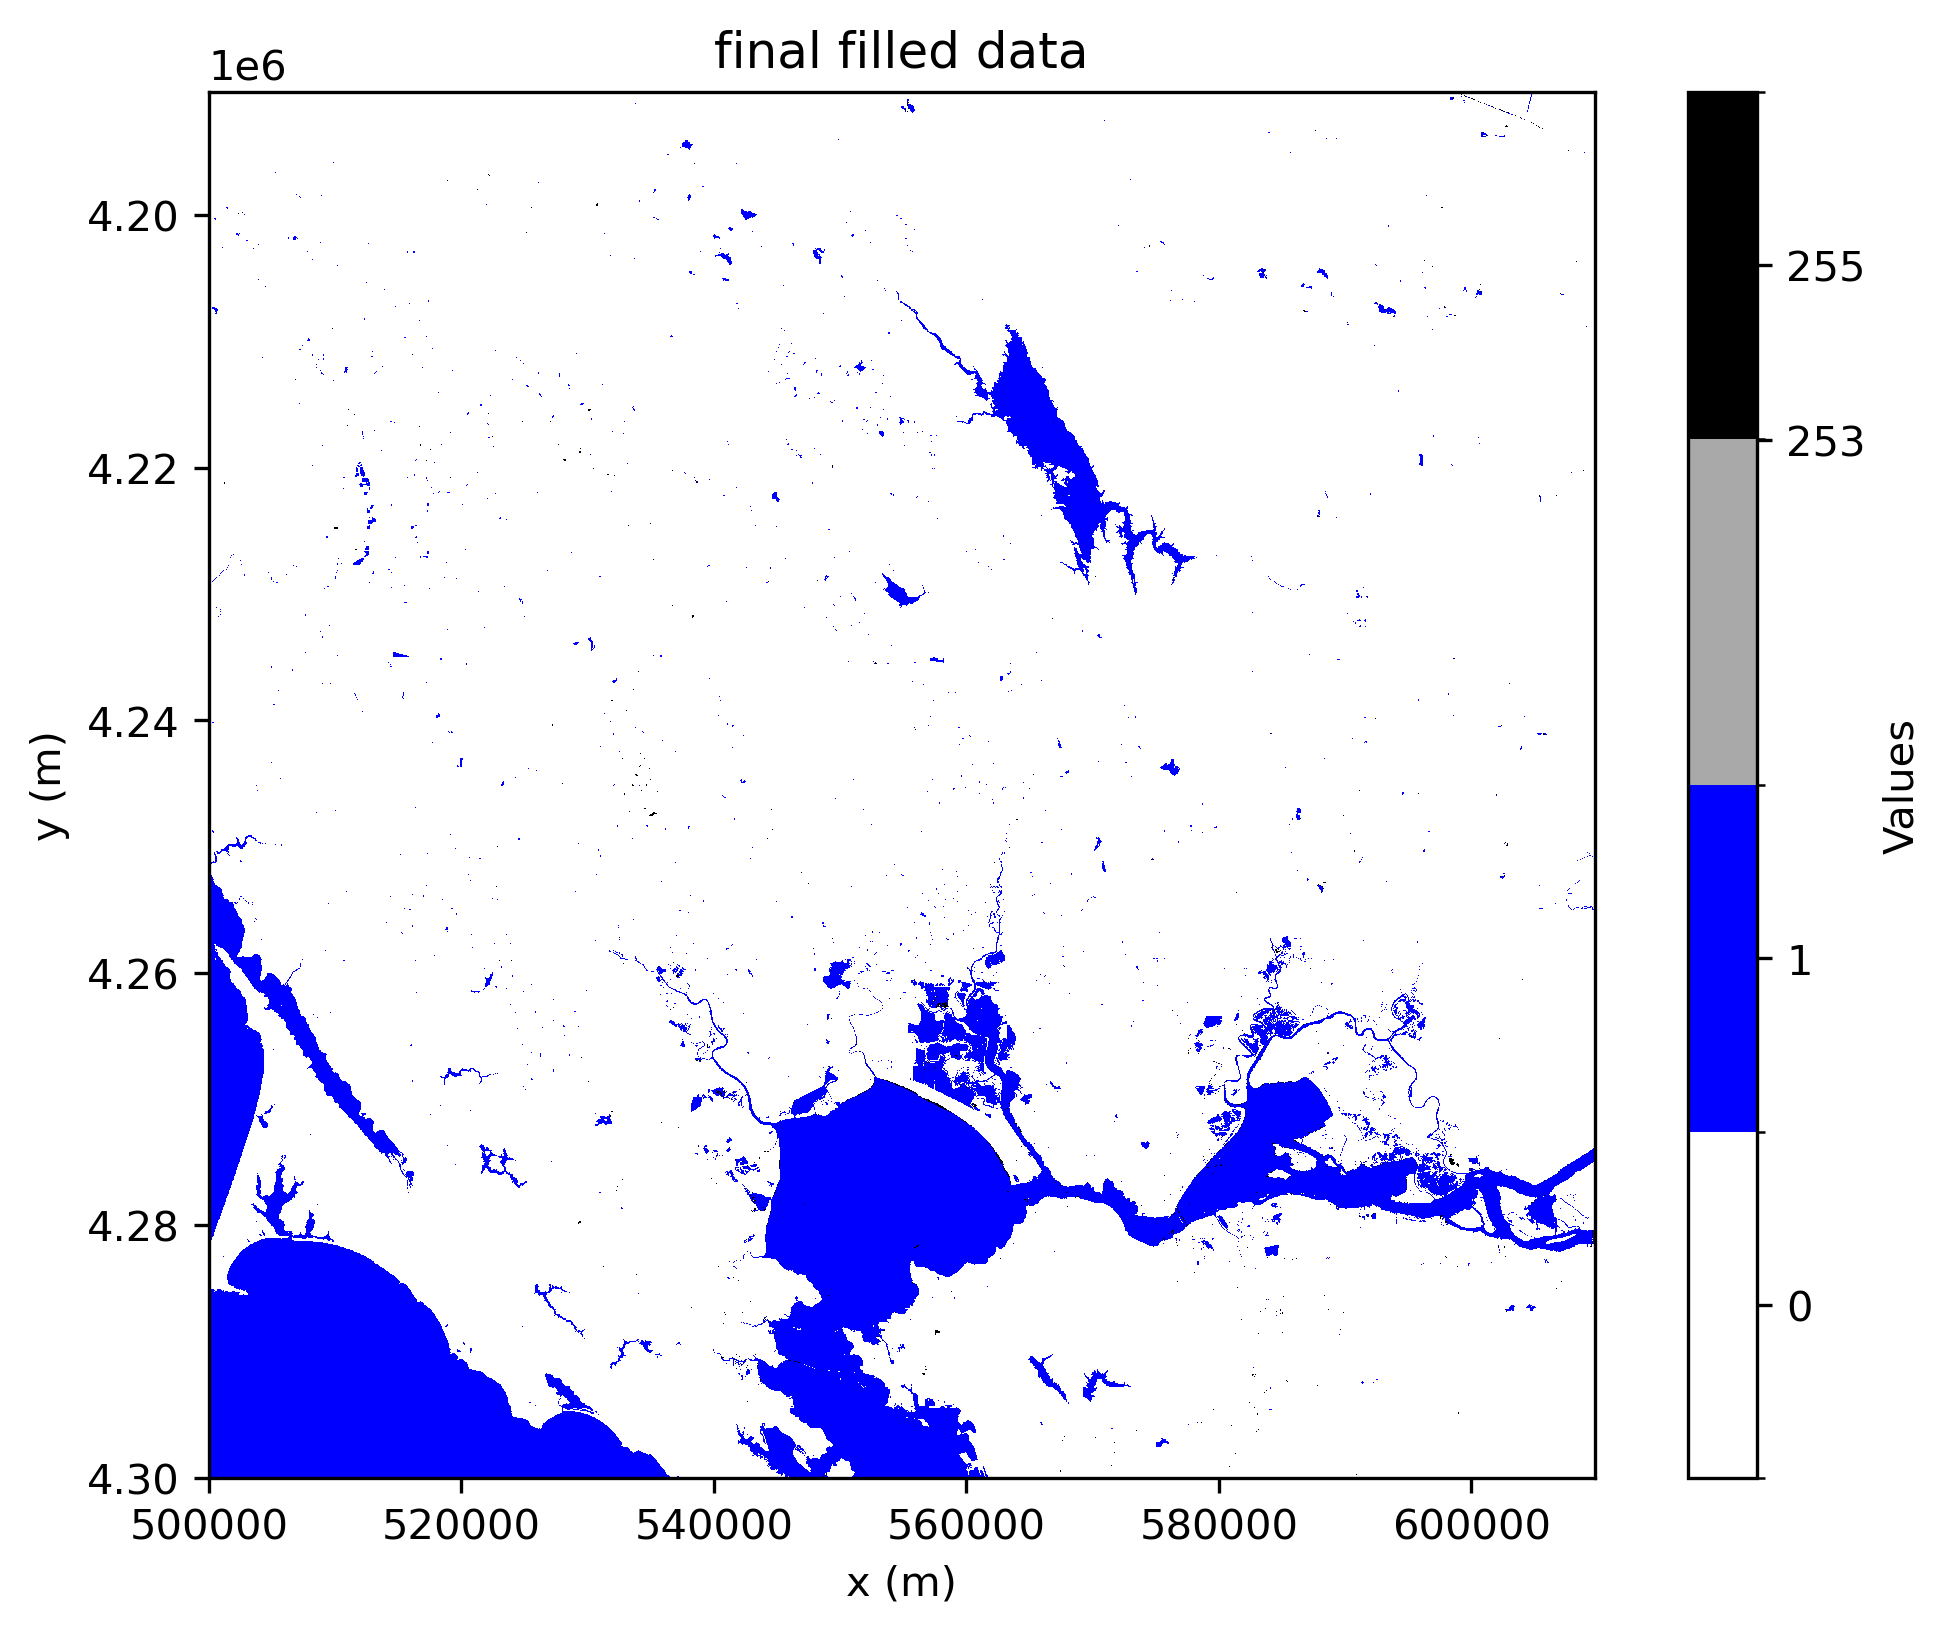

In [44]:
im = plt.figure()
im.set_dpi(300)
im.set_size_inches(8,6)
plt.imshow(final_data, cmap=HLS_cmap, norm=HLS_norm, interpolation='none', extent=[x[0], x[-1], y[0], y[-1]]) 
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('final filled data')
#plt.clim(clim_uwr)
plt.colorbar(ticks=[0, 1, 253, 255], label='Values')


In [45]:
np.save(test_fp[0:-4] + ".npy",final_data)


In [46]:
np.sum(fill_data==253), len(features_test_data)

(46257, 109229)